In [20]:
import os
import openai
import dotenv
from openai import OpenAI

# import key
dotenv.load_dotenv()  # Loads variables from your .env file
openai.api_key = os.getenv("OPENAI_API_KEY")

In [21]:
client = OpenAI()

In [28]:
text_input = """"
I was prescribed this drug because I had spent a whole night in complete agony; abdominal pain, lower back pain, all that I imagine labor pain to be, except I was not in labor.
Though the cause of my pain remains undetermined, the Arthrotec combined with Paracetamol pretty much eliminated the pain.
This was a big relief, as the 1200 MG of Ibuprofen I had taken throughout the night had done nothing.
I only took 1 Arthrotec and 1 Paracetamol and that did the trick.
HOWEVER: I had a very bad headache yesterday and Ibuprofen again didn't work.
I still had the other Arthrotec pills left, so I took one.
Although it alleviated the pain, I got up this morning with heavy vaginal bleeding even though my period ended last week.
I was relieved to read that this could be a side effect, as it means I probably don't have something serious, but I will have to be in some serious pain to risk bleeding from the vagina again.
Next time I'll try my luck with Paracetamol.
The pill I took consisted of 50 MG Diclofenac and 200 MG Misoprostol.
"""

prompt = """"
You are a specialized medical text analysis system for identifying and extracting medical entities from patient forum posts and clinical narratives using Named Entity Recognition with BIO tagging methodology.

OBJECTIVE: Perform precise extraction and classification of medical entities from unstructured medical text, focusing on patient-reported experiences, clinical observations, and drug-related discussions.

TARGET ENTITY CATEGORIES:
ADR (Adverse Drug Reactions): Unwanted or harmful reactions experienced after medication administration. This encompasses side effects, allergic reactions, drug intolerance, toxicity symptoms, and any negative physiological responses directly attributable to pharmaceutical interventions. Include both immediate and delayed reactions, mild to severe manifestations.
Drug: Pharmaceutical substances including generic names, brand names, trade names, abbreviations, combination drugs, dosage forms, and colloquial medication references. This category contains generic names, trade names, abbreviations, and dosage forms adjacent to the drug. Include over-the-counter medications, prescription drugs, supplements, and herbal remedies.
Disease: Medical conditions, disorders, illnesses, diagnoses, pathological states, and chronic conditions. This encompasses confirmed diagnoses, suspected conditions, medical history items, and both acute and chronic health states requiring medical intervention or monitoring.
Symptom: Physical manifestations, subjective experiences, clinical signs, and patient-reported sensations that indicate illness or medical conditions. Distinguished from ADRs by their relationship to underlying pathology rather than medication effects.

ANNOTATION METHODOLOGY:
Step 1 - BIO Sequence Labeling: Apply BIO (Beginning-Inside-Outside) tagging where each word receives labels: B-[ENTITY] for entity beginnings, I-[ENTITY] for entity continuations, and O for non-entities. Annotate entities with start and end character positions for precise boundary identification.
Step 2 - Structured Output Generation: Transform BIO annotations into standardized format: T[ID] [LABEL] [START] [END] [TEXT]
* T[ID]: Sequential identifier (T1, T2, T3...)
* [LABEL]: Entity category (ADR, Drug, Disease, Symptom)
* [START] [END]: Character-level positions in original text
* [TEXT]: Exact extracted entity span

ANNOTATION PRINCIPLES:
Contextual Disambiguation: Distinguish between similar terms based on medical context. For example, "pain relief" indicates therapeutic effect rather than symptom, while "severe pain" represents a symptom requiring attention.
Multi-word Entity Handling: Complex medical terms spanning multiple tokens receive B- labels for initial words and I- labels for subsequent components, ensuring complete entity capture.
Patient Language Recognition: Medical forum posts contain patient-reported adverse drug events using colloquial expressions. Recognize informal descriptions like "feeling weird," "brain fog," or "zonked out" as valid ADR mentions.
Boundary Precision: Calculate character positions accurately, accounting for whitespace and punctuation to enable exact text reconstruction and downstream processing applications.

EXAMPLE PROCESSING:
Input: "Started Lexapro last week but experiencing terrible nausea and dizziness from anxiety disorder treatment"
BIO Sequence:
Started O | Lexapro B-Drug | last O | week O | but O | experiencing O | terrible O | nausea B-ADR | and O | dizziness B-ADR | from O | anxiety B-Disease | disorder I-Disease | treatment O
Structured Output:
T1 Drug 8 15 Lexapro
T2 ADR 52 58 nausea  
T3 ADR 63 72 dizziness
T4 Disease 78 93 anxiety disorder

Dont use ### or any other markdown formatting in the output. Keep it in simple text format.
Return both the BIO sequence and structured output in a single response.

QUALITY REQUIREMENTS:
* Maintain high precision in entity boundary detection
* Preserve original text character positions for traceability
* Handle complex pharmaceutical nomenclature and medical terminology
* Recognize both formal medical language and patient vernacular
* Ensure consistent annotation across similar contexts
This systematic approach enables robust extraction of medical entities for pharmacovigilance applications, clinical decision support, and biomedical research initiatives.
"""

def medical_ner(text_input, prompt):
    response = client.responses.create(
        model="gpt-4o-mini",
        instructions=prompt,
        input=text_input)
    return response.output_text

In [32]:
import os
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

error_files = []

# Define your input and output directories
input_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/text"
output_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get a list of text files in the input directory
files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]

def process_file(filename):
    try:
        output_filepath = os.path.join(output_dir, filename)
        # Skip processing if the file is already processed
        if os.path.exists(output_filepath):
            print(f"\nFile {filename} already processed. Skipping...")
            return
        input_filepath = os.path.join(input_dir, filename)
        with open(input_filepath, "r", encoding="utf-8") as file:
            text_input = file.read()
        
        # Process the text with your medical_ner function defined in scratchpad.ipynb
        output_text = medical_ner(text_input, prompt)
        
        # Write the response to the output directory with the same file name
        with open(output_filepath, "w", encoding="utf-8") as outfile:
            outfile.write(output_text)
        
        print(f"\nProcessed {filename} and saved output to {output_filepath}")
    except Exception as e:
        print(f"\nError processing {filename}: {e}")
        error_files.append(filename)

# Process files in batches of 5 concurrently
for i in tqdm(range(0, len(files), 5), desc="Processing batches of 5 files"):
    batch = files[i:i+5]
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(process_file, filename) for filename in batch]
        for future in as_completed(futures):
            future.result()

if error_files:
    print("\nFiles with errors:")
    for fname in error_files:
        print(f"- {fname}")

Processing batches of 5 files:   0%|          | 0/250 [00:00<?, ?it/s]


File LIPITOR.86.txt already processed. Skipping...
File LIPITOR.92.txt already processed. Skipping...


File LIPITOR.952.txt already processed. Skipping...

File LIPITOR.45.txt already processed. Skipping...

File LIPITOR.946.txt already processed. Skipping...

File LIPITOR.775.txt already processed. Skipping...

File LIPITOR.761.txt already processed. Skipping...

File LIPITOR.51.txt already processed. Skipping...

File LIPITOR.79.txt already processed. Skipping...

File LIPITOR.991.txt already processed. Skipping...

File LIPITOR.749.txt already processed. Skipping...

File LIPITOR.985.txt already processed. Skipping...

File LIPITOR.588.txt already processed. Skipping...

File LIPITOR.577.txt already processed. Skipping...

File LIPITOR.211.txt already processed. Skipping...

File LIPITOR.205.txt already processed. Skipping...

File LIPITOR.563.txt already processed. Skipping...

File VOLTAREN.22.txt already processed. Skipping...

File ARTHROTEC.2.txt already processed. Skipping..

Processing batches of 5 files:  19%|█▉        | 47/250 [00:00<00:02, 72.05it/s]


Error processing LIPITOR.40.txt: Error code: 400 - {'error': {'message': 'One of "input" or "previous_response_id" or \'prompt\' must be provided.', 'type': 'invalid_request_error', 'param': None, 'code': 'missing_required_parameter'}}

File LIPITOR.54.txt already processed. Skipping...

File LIPITOR.764.txt already processed. Skipping...

File LIPITOR.599.txt already processed. Skipping...

File ARTHROTEC.7.txt already processed. Skipping...

File LIPITOR.228.txt already processed. Skipping...

File VOLTAREN.27.txt already processed. Skipping...

File LIPITOR.9.txt already processed. Skipping...

File LIPITOR.214.txt already processed. Skipping...

File VOLTAREN.33.txt already processed. Skipping...

File LIPITOR.572.txt already processed. Skipping...

File LIPITOR.566.txt already processed. Skipping...

File LIPITOR.200.txt already processed. Skipping...

File ARTHROTEC.12.txt already processed. Skipping...

File LIPITOR.348.txt already processed. Skipping...

File LIPITOR.360.txt a

Processing batches of 5 files:  27%|██▋       | 68/250 [00:26<01:27,  2.08it/s]


Processed LIPITOR.887.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.887.txt

Processed LIPITOR.139.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.139.txt

Processed LIPITOR.677.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.677.txt

Processed LIPITOR.105.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.105.txt


Processing batches of 5 files:  28%|██▊       | 69/250 [00:36<02:15,  1.34it/s]


Processed LIPITOR.663.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.663.txt

Processed LIPITOR.111.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.111.txt

Processed LIPITOR.688.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.688.txt

Processed ARTHROTEC.61.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.61.txt

Processed LIPITOR.844.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.844.txt

Processed LIPITOR.850.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.850.txt


Processing batches of 5 files:  28%|██▊       | 70/250 [00:53<03:58,  1.33s/it]


Processed LIPITOR.878.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.878.txt

Processed LIPITOR.313.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.313.txt

Processed LIPITOR.449.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.449.txt

Processed CATAFLAM.10.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CATAFLAM.10.txt

Processed LIPITOR.475.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.475.txt


Processing batches of 5 files:  28%|██▊       | 71/250 [01:00<04:46,  1.60s/it]


Processed ARTHROTEC.75.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.75.txt

Processed ARTHROTEC.49.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.49.txt

Processed VOLTAREN-XR.22.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.22.txt

Processed LIPITOR.307.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.307.txt

Processed VOLTAREN.40.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.40.txt

Processed LIPITOR.461.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.461.txt

Processed LIPITOR.529.txt and saved output to /Users/thyag/Deskto

Processing batches of 5 files:  28%|██▊       | 71/250 [01:15<04:46,  1.60s/it]


Processed LIPITOR.501.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.501.txt

Processed LIPITOR.515.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.515.txt


Processing batches of 5 files:  29%|██▉       | 73/250 [01:28<09:06,  3.09s/it]


Processed LIPITOR.273.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.273.txt

Processed ARTHROTEC.128.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.128.txt

Processed LIPITOR.33.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.33.txt

Processed ARTHROTEC.100.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.100.txt

Processed LIPITOR.298.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.298.txt


Processing batches of 5 files:  30%|██▉       | 74/250 [01:34<09:44,  3.32s/it]


Processed ARTHROTEC.114.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.114.txt

Processed LIPITOR.930.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.930.txt

Processed LIPITOR.924.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.924.txt

Processed LIPITOR.717.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.717.txt

Processed LIPITOR.27.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.27.txt


Processing batches of 5 files:  30%|███       | 75/250 [01:56<15:15,  5.23s/it]


Processed LIPITOR.703.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.703.txt

Processed LIPITOR.918.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.918.txt

Processed LIPITOR.31.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.31.txt

Processed LIPITOR.932.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.932.txt

Processed LIPITOR.701.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.701.txt


Processing batches of 5 files:  30%|███       | 76/250 [02:13<19:27,  6.71s/it]


Processed LIPITOR.926.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.926.txt

Processed ARTHROTEC.116.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.116.txt

Processed LIPITOR.19.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.19.txt

Processed LIPITOR.729.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.729.txt

Processed LIPITOR.25.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.25.txt


Processing batches of 5 files:  31%|███       | 77/250 [02:20<19:17,  6.69s/it]


Processed LIPITOR.715.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.715.txt

Processed LIPITOR.271.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.271.txt

Processed LIPITOR.265.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.265.txt

Processed ARTHROTEC.102.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.102.txt

Processed LIPITOR.503.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.503.txt


Processing batches of 5 files:  31%|███       | 78/250 [02:30<21:21,  7.45s/it]


Processed LIPITOR.517.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.517.txt

Processed ARTHROTEC.88.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.88.txt

Processed VOLTAREN.42.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.42.txt

Processed VOLTAREN-XR.20.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.20.txt

Processed LIPITOR.259.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.259.txt


Processing batches of 5 files:  32%|███▏      | 79/250 [02:43<24:27,  8.58s/it]


Processed LIPITOR.488.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.488.txt

Processed LIPITOR.311.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.311.txt

Processed LIPITOR.477.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.477.txt

Processed LIPITOR.463.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.463.txt

Processed LIPITOR.305.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.305.txt


Processing batches of 5 files:  32%|███▏      | 80/250 [02:55<26:04,  9.20s/it]


Processed ARTHROTEC.63.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.63.txt

Processed LIPITOR.852.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.852.txt

Processed LIPITOR.675.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.675.txt

Processed ARTHROTEC.77.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.77.txt

Processed LIPITOR.846.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.846.txt


Processing batches of 5 files:  32%|███▏      | 81/250 [03:08<28:29, 10.12s/it]


Processed LIPITOR.339.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.339.txt

Processed LIPITOR.649.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.649.txt
Processed LIPITOR.113.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.113.txt


Processed LIPITOR.107.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.107.txt

Processed LIPITOR.891.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.891.txt


Processing batches of 5 files:  33%|███▎      | 82/250 [03:20<29:44, 10.62s/it]


Processed LIPITOR.661.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.661.txt

Processed VOLTAREN.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.3.txt

Processed VOLTAREN.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.2.txt

Processed LIPITOR.885.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.885.txt

Processed LIPITOR.884.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.884.txt


Processing batches of 5 files:  33%|███▎      | 83/250 [03:36<33:30, 12.04s/it]


Processed LIPITOR.890.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.890.txt

Processed LIPITOR.648.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.648.txt

Processed LIPITOR.106.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.106.txt


Processing batches of 5 files:  34%|███▎      | 84/250 [04:12<51:44, 18.70s/it]


Error processing LIPITOR.674.txt: Request timed out.

Error processing LIPITOR.112.txt: Request timed out.

Error processing LIPITOR.660.txt: Request timed out.


Processing batches of 5 files:  34%|███▍      | 85/250 [05:05<1:18:16, 28.47s/it]


Error processing LIPITOR.338.txt: Connection error.
Error processing ARTHROTEC.62.txt: Connection error.


Error processing LIPITOR.853.txt: Connection error.

Error processing LIPITOR.847.txt: Connection error.

Error processing ARTHROTEC.76.txt: Connection error.

Processed LIPITOR.476.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.476.txt

Processed LIPITOR.489.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.489.txt

Processed LIPITOR.462.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.462.txt

Processed LIPITOR.310.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.310.txt


Processing batches of 5 files:  34%|███▍      | 86/250 [05:26<1:12:22, 26.48s/it]


Processed LIPITOR.304.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.304.txt

Processed VOLTAREN.43.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.43.txt

Processed ARTHROTEC.89.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.89.txt

Processed LIPITOR.516.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.516.txt

Processed VOLTAREN-XR.21.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.21.txt


Processing batches of 5 files:  35%|███▍      | 87/250 [05:45<1:05:47, 24.22s/it]


Processed LIPITOR.258.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.258.txt

Processed LIPITOR.270.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.270.txt

Processed ARTHROTEC.117.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.117.txt

Processed ARTHROTEC.103.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.103.txt

Processed LIPITOR.502.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.502.txt


Processing batches of 5 files:  35%|███▌      | 88/250 [06:13<1:08:46, 25.47s/it]


Processed LIPITOR.264.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.264.txt

Processed LIPITOR.714.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.714.txt

Processed LIPITOR.24.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.24.txt

Processed LIPITOR.728.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.728.txt

Processed LIPITOR.700.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.700.txt


Processing batches of 5 files:  36%|███▌      | 89/250 [06:47<1:14:48, 27.88s/it]


Processed LIPITOR.18.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.18.txt

Processed LIPITOR.933.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.933.txt

Processed LIPITOR.927.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.927.txt

Processed LIPITOR.30.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.30.txt


Processing batches of 5 files:  36%|███▌      | 90/250 [07:18<1:16:55, 28.85s/it]


Processed LIPITOR.923.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.923.txt

Processed LIPITOR.937.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.937.txt

Processed LIPITOR.738.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.738.txt

Processed LIPITOR.20.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.20.txt

Processed LIPITOR.710.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.710.txt

Processed LIPITOR.34.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.34.txt


Processing batches of 5 files:  36%|███▋      | 91/250 [07:50<1:19:01, 29.82s/it]


Processed LIPITOR.704.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.704.txt

Processed ARTHROTEC.107.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.107.txt

Processed LIPITOR.248.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.248.txt

Processed LIPITOR.506.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.506.txt

Processed LIPITOR.260.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.260.txt


Processing batches of 5 files:  37%|███▋      | 92/250 [08:05<1:06:20, 25.19s/it]


Processed ARTHROTEC.113.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.113.txt

Processed LIPITOR.512.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.512.txt

Processed LIPITOR.499.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.499.txt

Processed LIPITOR.274.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.274.txt

Processed VOLTAREN-XR.19.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.19.txt


Processing batches of 5 files:  37%|███▋      | 93/250 [08:11<51:34, 19.71s/it]  


Processed ARTHROTEC.99.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.99.txt

Processed ARTHROTEC.72.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.72.txt

Processed ARTHROTEC.66.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.66.txt

Processed LIPITOR.328.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.328.txt

Processed LIPITOR.472.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.472.txt


Processing batches of 5 files:  38%|███▊      | 94/250 [08:26<46:50, 18.01s/it]


Processed LIPITOR.314.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.314.txt

Processed LIPITOR.843.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.843.txt

Processed LIPITOR.857.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.857.txt

Processed LIPITOR.300.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.300.txt

Processed LIPITOR.894.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.894.txt


Processing batches of 5 files:  38%|███▊      | 95/250 [08:34<39:23, 15.25s/it]


Processed LIPITOR.466.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.466.txt

Processed LIPITOR.670.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.670.txt

Processed LIPITOR.880.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.880.txt

Processed LIPITOR.116.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.116.txt

Processed VOLTAREN.7.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.7.txt


Processing batches of 5 files:  38%|███▊      | 96/250 [08:43<34:25, 13.41s/it]


Processed LIPITOR.658.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.658.txt

Processed LIPITOR.102.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.102.txt

Processed LIPITOR.664.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.664.txt

Processed LIPITOR.103.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.103.txt

Processed LIPITOR.665.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.665.txt


Processing batches of 5 files:  39%|███▉      | 97/250 [09:03<38:38, 15.15s/it]


Processed LIPITOR.117.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.117.txt

Processed LIPITOR.895.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.895.txt

Processed LIPITOR.881.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.881.txt

Processed LIPITOR.659.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.659.txt

Processed VOLTAREN.6.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.6.txt


Processing batches of 5 files:  39%|███▉      | 98/250 [09:13<34:36, 13.66s/it]


Processed LIPITOR.671.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.671.txt

Processed LIPITOR.467.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.467.txt

Processed LIPITOR.301.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.301.txt

Processed LIPITOR.473.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.473.txt

Processed LIPITOR.842.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.842.txt


Processing batches of 5 files:  40%|███▉      | 99/250 [09:26<34:02, 13.52s/it]


Processed LIPITOR.856.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.856.txt

Processed ARTHROTEC.98.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.98.txt

Processed LIPITOR.329.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.329.txt

Processed ARTHROTEC.67.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.67.txt

Processed ARTHROTEC.73.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.73.txt


Processing batches of 5 files:  40%|████      | 100/250 [09:35<30:21, 12.14s/it]


Processed LIPITOR.315.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.315.txt

Processed VOLTAREN-XR.18.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.18.txt

Processed LIPITOR.513.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.513.txt

Processed LIPITOR.498.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.498.txt

Processed LIPITOR.275.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.275.txt


Processing batches of 5 files:  40%|████      | 101/250 [09:54<35:31, 14.30s/it]


Processed LIPITOR.507.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.507.txt

Processed ARTHROTEC.106.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.106.txt

Processed ARTHROTEC.112.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.112.txt

Processed VOLTAREN.46.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.46.txt

Processed LIPITOR.261.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.261.txt


Processing batches of 5 files:  41%|████      | 102/250 [10:11<37:03, 15.02s/it]


Processed LIPITOR.249.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.249.txt

Processed LIPITOR.711.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.711.txt

Processed LIPITOR.21.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.21.txt

Processed LIPITOR.35.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.35.txt

Processed LIPITOR.705.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.705.txt


Processing batches of 5 files:  41%|████      | 103/250 [10:22<34:07, 13.93s/it]


Processed LIPITOR.739.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.739.txt

Processed LIPITOR.908.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.908.txt

Processed LIPITOR.922.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.922.txt

Processed LIPITOR.920.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.920.txt

Processed LIPITOR.934.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.934.txt


Processing batches of 5 files:  42%|████▏     | 104/250 [10:29<28:21, 11.65s/it]


Processed LIPITOR.936.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.936.txt

Processed LIPITOR.23.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.23.txt

Processed ARTHROTEC.138.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.138.txt

Processed LIPITOR.37.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.37.txt

Processed LIPITOR.707.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.707.txt


Processing batches of 5 files:  42%|████▏     | 105/250 [10:44<30:42, 12.71s/it]


Processed LIPITOR.713.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.713.txt

Processed LIPITOR.539.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.539.txt

Processed LIPITOR.288.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.288.txt

Processed ARTHROTEC.110.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.110.txt

Processed ARTHROTEC.104.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.104.txt


Processing batches of 5 files:  42%|████▏     | 106/250 [10:53<27:52, 11.62s/it]


Processed VOLTAREN.44.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.44.txt

Processed LIPITOR.277.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.277.txt

Processed LIPITOR.505.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.505.txt

Processed LIPITOR.263.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.263.txt

Processed ARTHROTEC.71.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.71.txt


Processing batches of 5 files:  43%|████▎     | 107/250 [11:02<25:40, 10.77s/it]


Processed LIPITOR.511.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.511.txt

Processed LIPITOR.303.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.303.txt

Processed LIPITOR.459.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.459.txt

Processed ARTHROTEC.65.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.65.txt

Processed LIPITOR.317.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.317.txt


Processing batches of 5 files:  43%|████▎     | 108/250 [11:21<31:18, 13.23s/it]


Processed LIPITOR.465.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.465.txt

Processed LIPITOR.698.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.698.txt

Processed LIPITOR.471.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.471.txt

Processed LIPITOR.854.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.854.txt

Processed ARTHROTEC.59.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.59.txt


Processing batches of 5 files:  44%|████▎     | 109/250 [11:37<33:08, 14.10s/it]


Processed LIPITOR.840.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.840.txt

Error processing VOLTAREN-XR.9.txt: Error code: 400 - {'error': {'message': 'One of "input" or "previous_response_id" or \'prompt\' must be provided.', 'type': 'invalid_request_error', 'param': None, 'code': 'missing_required_parameter'}}

Processed LIPITOR.868.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.868.txt

Processed VOLTAREN.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.4.txt

Processed LIPITOR.883.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.883.txt


Processing batches of 5 files:  44%|████▍     | 110/250 [11:45<28:30, 12.22s/it]


Processed LIPITOR.897.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.897.txt

Processed LIPITOR.101.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.101.txt

Processed LIPITOR.667.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.667.txt

Processed LIPITOR.115.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.115.txt

Processed LIPITOR.673.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.673.txt


Processing batches of 5 files:  44%|████▍     | 111/250 [11:53<25:17, 10.92s/it]


Processed LIPITOR.129.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.129.txt

Processed LIPITOR.666.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.666.txt

Processed LIPITOR.100.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.100.txt

Processed LIPITOR.896.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.896.txt

Processed LIPITOR.114.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.114.txt


Processing batches of 5 files:  45%|████▍     | 112/250 [12:06<27:03, 11.76s/it]


Processed LIPITOR.672.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.672.txt

Processed LIPITOR.869.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.869.txt

Processed LIPITOR.128.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.128.txt

Processed VOLTAREN-XR.8.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.8.txt

Processed VOLTAREN.5.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.5.txt


Processing batches of 5 files:  45%|████▌     | 113/250 [12:19<27:21, 11.98s/it]


Processed LIPITOR.882.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.882.txt

Processed LIPITOR.855.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.855.txt

Processed LIPITOR.316.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.316.txt

Processed LIPITOR.699.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.699.txt

Processed LIPITOR.470.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.470.txt


Processing batches of 5 files:  46%|████▌     | 114/250 [12:29<25:37, 11.30s/it]


Processed LIPITOR.841.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.841.txt

Processed ARTHROTEC.58.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.58.txt

Processed ARTHROTEC.64.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.64.txt

Processed LIPITOR.464.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.464.txt

Processed LIPITOR.302.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.302.txt


Processing batches of 5 files:  46%|████▌     | 115/250 [12:46<29:37, 13.17s/it]


Processed LIPITOR.458.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.458.txt

Processed LIPITOR.510.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.510.txt

Processed ARTHROTEC.70.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.70.txt

Processed LIPITOR.276.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.276.txt

Processed LIPITOR.262.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.262.txt


Processing batches of 5 files:  46%|████▋     | 116/250 [12:56<27:34, 12.35s/it]


Processed LIPITOR.504.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.504.txt

Processed VOLTAREN.45.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.45.txt

Processed LIPITOR.538.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.538.txt

Processed ARTHROTEC.111.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.111.txt

Processed ARTHROTEC.105.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.105.txt


Processing batches of 5 files:  47%|████▋     | 117/250 [13:04<24:23, 11.01s/it]


Processed LIPITOR.289.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.289.txt

Processed LIPITOR.712.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.712.txt

Processed ARTHROTEC.139.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.139.txt

Processed LIPITOR.22.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.22.txt

Processed LIPITOR.36.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.36.txt


Processing batches of 5 files:  47%|████▋     | 118/250 [13:14<23:22, 10.63s/it]


Processed LIPITOR.706.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.706.txt

Processed LIPITOR.921.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.921.txt

Processed LIPITOR.910.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.910.txt

Processed LIPITOR.938.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.938.txt

Processed LIPITOR.909.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.909.txt


Processing batches of 5 files:  48%|████▊     | 119/250 [13:28<25:33, 11.71s/it]


Processed LIPITOR.935.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.935.txt

Processed LIPITOR.723.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.723.txt

Processed LIPITOR.737.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.737.txt

Processed ARTHROTEC.120.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.120.txt

Processed LIPITOR.13.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.13.txt


Processing batches of 5 files:  48%|████▊     | 120/250 [13:38<23:46, 10.98s/it]


Processed LIPITOR.904.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.904.txt

Processed LIPITOR.290.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.290.txt

Processed ARTHROTEC.108.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.108.txt

Processed ARTHROTEC.134.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.134.txt

Processed LIPITOR.253.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.253.txt


Processing batches of 5 files:  48%|████▊     | 121/250 [13:50<24:17, 11.30s/it]


Processed LIPITOR.284.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.284.txt

Processed LIPITOR.509.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.509.txt

Processed LIPITOR.521.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.521.txt

Processed VOLTAREN-XR.16.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.16.txt

Processed LIPITOR.247.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.247.txt


Processing batches of 5 files:  49%|████▉     | 122/250 [14:06<27:18, 12.80s/it]


Processed LIPITOR.535.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.535.txt

Processed ARTHROTEC.82.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.82.txt

Processed LIPITOR.482.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.482.txt

Processed ARTHROTEC.96.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.96.txt

Processed LIPITOR.496.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.496.txt


Processing batches of 5 files:  49%|████▉     | 123/250 [14:28<33:14, 15.71s/it]


Processed LIPITOR.327.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.327.txt

Processed LIPITOR.333.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.333.txt

Processed ARTHROTEC.55.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.55.txt

Processed ARTHROTEC.69.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.69.txt

Processed LIPITOR.441.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.441.txt


Processing batches of 5 files:  50%|████▉     | 124/250 [14:35<27:28, 13.09s/it]


Processed LIPITOR.455.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.455.txt

Processed LIPITOR.469.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.469.txt

Processed LIPITOR.680.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.680.txt

Processed LIPITOR.858.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.858.txt

Processed ARTHROTEC.41.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.41.txt


Processing batches of 5 files:  50%|█████     | 125/250 [14:52<29:46, 14.29s/it]


Processed LIPITOR.694.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.694.txt

Processed LIPITOR.864.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.864.txt

Processed LIPITOR.125.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.125.txt

Processed DICLOFENAC-SODIUM.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.2.txt

Processed LIPITOR.870.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.870.txt


Processing batches of 5 files:  50%|█████     | 126/250 [15:04<27:35, 13.35s/it]


Processed LIPITOR.643.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.643.txt

Processed LIPITOR.119.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.119.txt

Processed LIPITOR.657.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.657.txt

Processed VOLTAREN-XR.5.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.5.txt

Processed LIPITOR.131.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.131.txt


Processing batches of 5 files:  51%|█████     | 127/250 [15:16<26:39, 13.00s/it]


Processed VOLTAREN.8.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.8.txt

Processed VOLTAREN-XR.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.4.txt

Processed LIPITOR.118.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.118.txt

Processed VOLTAREN.9.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.9.txt

Processed LIPITOR.656.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.656.txt


Processing batches of 5 files:  51%|█████     | 128/250 [15:27<25:03, 12.32s/it]


Processed LIPITOR.130.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.130.txt

Processed LIPITOR.871.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.871.txt

Processed LIPITOR.124.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.124.txt

Processed LIPITOR.642.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.642.txt

Processed LIPITOR.865.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.865.txt


Processing batches of 5 files:  52%|█████▏    | 129/250 [15:43<27:11, 13.48s/it]


Processed DICLOFENAC-SODIUM.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.3.txt

Processed LIPITOR.695.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.695.txt

Processed LIPITOR.681.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.681.txt

Processed LIPITOR.468.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.468.txt

Processed ARTHROTEC.40.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.40.txt


Processing batches of 5 files:  52%|█████▏    | 130/250 [15:57<27:13, 13.62s/it]


Processed LIPITOR.859.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.859.txt

Processed ARTHROTEC.54.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.54.txt

Processed LIPITOR.440.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.440.txt

Processed LIPITOR.326.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.326.txt

Processed LIPITOR.332.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.332.txt


Processing batches of 5 files:  52%|█████▏    | 131/250 [16:02<22:11, 11.19s/it]


Processed LIPITOR.454.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.454.txt

Processed ARTHROTEC.83.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.83.txt

Processed VOLTAREN-XR.17.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.17.txt

Processed ARTHROTEC.97.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.97.txt

Processed ARTHROTEC.68.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.68.txt


Processing batches of 5 files:  53%|█████▎    | 132/250 [16:12<21:01, 10.69s/it]


Processed LIPITOR.497.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.497.txt

Processed LIPITOR.520.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.520.txt

Processed LIPITOR.252.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.252.txt

Processed LIPITOR.483.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.483.txt

Processed LIPITOR.246.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.246.txt


Processing batches of 5 files:  53%|█████▎    | 133/250 [16:38<29:59, 15.38s/it]


Processed LIPITOR.508.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.508.txt

Processed ARTHROTEC.109.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.109.txt

Processed LIPITOR.534.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.534.txt

Processed LIPITOR.291.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.291.txt

Processed ARTHROTEC.135.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.135.txt


Processing batches of 5 files:  54%|█████▎    | 134/250 [16:47<26:04, 13.49s/it]


Processed LIPITOR.285.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.285.txt

Processed LIPITOR.722.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.722.txt

Processed LIPITOR.905.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.905.txt

Processed LIPITOR.736.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.736.txt

Processed ARTHROTEC.121.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.121.txt


Processing batches of 5 files:  54%|█████▍    | 135/250 [17:00<25:31, 13.32s/it]


Processed LIPITOR.12.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.12.txt

Processed ZIPSOR.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ZIPSOR.4.txt

Processed LIPITOR.907.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.907.txt

Processed LIPITOR.911.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.911.txt

Processed LIPITOR.913.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.913.txt


Processing batches of 5 files:  54%|█████▍    | 136/250 [17:11<23:50, 12.55s/it]


Processed LIPITOR.939.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.939.txt

Processed LIPITOR.734.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.734.txt

Processed LIPITOR.720.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.720.txt

Processed LIPITOR.10.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.10.txt

Processed LIPITOR.38.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.38.txt


Processing batches of 5 files:  55%|█████▍    | 137/250 [17:29<27:02, 14.36s/it]


Processed LIPITOR.708.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.708.txt

Processed LIPITOR.293.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.293.txt

Processed LIPITOR.287.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.287.txt

Processed LIPITOR.244.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.244.txt

Processed ARTHROTEC.123.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.123.txt


Processing batches of 5 files:  55%|█████▌    | 138/250 [17:57<34:09, 18.30s/it]


Processed ARTHROTEC.137.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.137.txt

Processed LIPITOR.522.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.522.txt

Processed LIPITOR.250.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.250.txt

Processed LIPITOR.495.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.495.txt

Processed LIPITOR.278.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.278.txt


Processing batches of 5 files:  56%|█████▌    | 139/250 [18:11<31:36, 17.09s/it]


Processed LIPITOR.536.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.536.txt

Processed ARTHROTEC.81.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.81.txt

Processed VOLTAREN-XR.15.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.15.txt

Processed LIPITOR.330.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.330.txt

Processed ARTHROTEC.95.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.95.txt


Processing batches of 5 files:  56%|█████▌    | 140/250 [18:21<27:22, 14.93s/it]


Processed LIPITOR.481.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.481.txt

Processed LIPITOR.442.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.442.txt

Processed ARTHROTEC.56.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.56.txt

Processed LIPITOR.324.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.324.txt

Processed LIPITOR.456.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.456.txt


Processing batches of 5 files:  56%|█████▋    | 141/250 [18:45<32:06, 17.67s/it]


Processed ARTHROTEC.42.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.42.txt

Processed LIPITOR.697.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.697.txt

Processed LIPITOR.683.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.683.txt

Processed LIPITOR.867.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.867.txt

Processed LIPITOR.873.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.873.txt


Processing batches of 5 files:  57%|█████▋    | 142/250 [19:00<30:19, 16.85s/it]


Processed LIPITOR.318.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.318.txt

Processed VOLTAREN-XR.6.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.6.txt

Processed LIPITOR.132.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.132.txt

Processed LIPITOR.126.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.126.txt

Processed LIPITOR.654.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.654.txt


Processing batches of 5 files:  57%|█████▋    | 143/250 [19:09<25:48, 14.48s/it]


Processed DICLOFENAC-SODIUM.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.1.txt

Processed LIPITOR.127.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.127.txt

Processed LIPITOR.640.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.640.txt

Processed LIPITOR.668.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.668.txt

Processed LIPITOR.898.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.898.txt


Processing batches of 5 files:  58%|█████▊    | 144/250 [19:24<25:59, 14.71s/it]


Processed LIPITOR.669.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.669.txt

Processed VOLTAREN-XR.7.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.7.txt

Processed LIPITOR.655.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.655.txt

Processed LIPITOR.641.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.641.txt

Processed LIPITOR.133.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.133.txt


Processing batches of 5 files:  58%|█████▊    | 145/250 [19:40<26:24, 15.09s/it]


Processed LIPITOR.899.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.899.txt

Processed ARTHROTEC.57.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.57.txt

Processed LIPITOR.696.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.696.txt

Processed LIPITOR.682.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.682.txt

Processed LIPITOR.866.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.866.txt


Processing batches of 5 files:  58%|█████▊    | 146/250 [20:00<28:28, 16.43s/it]


Processed LIPITOR.872.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.872.txt

Processed LIPITOR.443.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.443.txt

Processed ARTHROTEC.43.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.43.txt

Processed LIPITOR.319.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.319.txt

Processed LIPITOR.325.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.325.txt


Processing batches of 5 files:  59%|█████▉    | 147/250 [20:20<30:20, 17.68s/it]


Processed LIPITOR.331.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.331.txt

Processed VOLTAREN-XR.14.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.14.txt

Processed LIPITOR.480.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.480.txt

Processed ARTHROTEC.94.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.94.txt

Processed ARTHROTEC.80.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.80.txt


Processing batches of 5 files:  59%|█████▉    | 148/250 [20:33<27:27, 16.15s/it]


Processed LIPITOR.457.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.457.txt

Processed LIPITOR.245.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.245.txt

Processed LIPITOR.251.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.251.txt

Processed LIPITOR.494.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.494.txt

Processed LIPITOR.279.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.279.txt


Processing batches of 5 files:  60%|█████▉    | 149/250 [20:52<28:26, 16.90s/it]


Processed LIPITOR.537.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.537.txt

Processed ARTHROTEC.136.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.136.txt

Processed LIPITOR.523.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.523.txt

Processed ARTHROTEC.122.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.122.txt

Processed LIPITOR.286.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.286.txt


Processing batches of 5 files:  60%|██████    | 150/250 [21:02<24:49, 14.90s/it]


Processed LIPITOR.292.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.292.txt

Processed LIPITOR.709.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.709.txt

Processed LIPITOR.39.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.39.txt

Processed LIPITOR.721.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.721.txt

Processed LIPITOR.735.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.735.txt


Processing batches of 5 files:  60%|██████    | 151/250 [21:15<23:45, 14.40s/it]


Processed LIPITOR.11.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.11.txt

Processed LIPITOR.902.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.902.txt

Processed LIPITOR.906.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.906.txt

Processed LIPITOR.912.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.912.txt

Processed LIPITOR.916.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.916.txt


Processing batches of 5 files:  61%|██████    | 152/250 [21:27<22:27, 13.75s/it]


Processed ZIPSOR.5.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ZIPSOR.5.txt

Processed ZIPSOR.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ZIPSOR.1.txt

Processed LIPITOR.719.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.719.txt

Processed LIPITOR.29.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.29.txt

Processed LIPITOR.725.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.725.txt


Processing batches of 5 files:  61%|██████    | 153/250 [21:41<22:16, 13.78s/it]


Processed LIPITOR.15.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.15.txt

Processed LIPITOR.296.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.296.txt

Processed LIPITOR.731.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.731.txt

Processed LIPITOR.282.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.282.txt

Processed ARTHROTEC.132.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.132.txt


Processing batches of 5 files:  62%|██████▏   | 154/250 [21:57<22:54, 14.32s/it]


Processed ARTHROTEC.126.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.126.txt

Processed LIPITOR.533.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.533.txt

Processed LIPITOR.241.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.241.txt

Processed LIPITOR.527.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.527.txt

Processed LIPITOR.255.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.255.txt


Processing batches of 5 files:  62%|██████▏   | 155/250 [22:19<26:22, 16.66s/it]


Processed LIPITOR.269.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.269.txt

Processed VOLTAREN-XR.10.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.10.txt

Processed ARTHROTEC.84.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.84.txt

Processed LIPITOR.490.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.490.txt

Processed ARTHROTEC.90.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.90.txt


Processing batches of 5 files:  62%|██████▏   | 156/250 [22:30<23:22, 14.92s/it]


Processed LIPITOR.484.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.484.txt

Processed ARTHROTEC.53.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.53.txt

Processed LIPITOR.453.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.453.txt

Processed LIPITOR.335.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.335.txt

Processed ARTHROTEC.47.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.47.txt


Processing batches of 5 files:  63%|██████▎   | 157/250 [22:38<19:49, 12.79s/it]


Processed LIPITOR.309.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.309.txt

Processed LIPITOR.876.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.876.txt

Processed LIPITOR.447.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.447.txt

Processed LIPITOR.862.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.862.txt

Processed LIPITOR.321.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.321.txt


Processing batches of 5 files:  63%|██████▎   | 158/250 [22:45<17:11, 11.21s/it]


Processed LIPITOR.692.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.692.txt

Processed LIPITOR.679.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.679.txt

Processed LIPITOR.651.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.651.txt

Processed LIPITOR.137.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.137.txt

Processed LIPITOR.686.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.686.txt


Processing batches of 5 files:  64%|██████▎   | 159/250 [22:59<18:04, 11.92s/it]


Processed VOLTAREN-XR.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.3.txt

Processed LIPITOR.889.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.889.txt

Processed LIPITOR.645.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.645.txt

Processed DICLOFENAC-SODIUM.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.4.txt

Processed LIPITOR.123.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.123.txt


Processing batches of 5 files:  64%|██████▍   | 160/250 [23:04<14:51,  9.91s/it]


Processed LIPITOR.644.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.644.txt

Processed LIPITOR.888.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.888.txt

Processed LIPITOR.122.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.122.txt

Processed DICLOFENAC-SODIUM.5.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.5.txt

Processed VOLTAREN-XR.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.2.txt


Processing batches of 5 files:  64%|██████▍   | 161/250 [23:10<12:48,  8.64s/it]


Processed LIPITOR.136.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.136.txt

Processed LIPITOR.863.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.863.txt

Processed LIPITOR.650.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.650.txt

Processed LIPITOR.678.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.678.txt

Processed LIPITOR.693.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.693.txt


Processing batches of 5 files:  65%|██████▍   | 162/250 [23:32<18:51, 12.85s/it]


Processed LIPITOR.687.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.687.txt

Processed LIPITOR.877.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.877.txt

Processed LIPITOR.320.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.320.txt

Processed LIPITOR.446.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.446.txt

Processed LIPITOR.452.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.452.txt


Processing batches of 5 files:  65%|██████▌   | 163/250 [23:43<17:47, 12.27s/it]


Processed LIPITOR.334.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.334.txt

Processed VOLTAREN-XR.11.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.11.txt

Processed LIPITOR.308.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.308.txt

Processed LIPITOR.485.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.485.txt

Processed ARTHROTEC.46.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.46.txt


Processing batches of 5 files:  66%|██████▌   | 164/250 [23:49<14:59, 10.46s/it]


Processed ARTHROTEC.52.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.52.txt

Processed ARTHROTEC.91.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.91.txt

Processed LIPITOR.532.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.532.txt

Processed ARTHROTEC.85.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.85.txt

Processed LIPITOR.254.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.254.txt


Processing batches of 5 files:  66%|██████▌   | 165/250 [24:01<15:18, 10.81s/it]


Processed LIPITOR.491.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.491.txt

Processed LIPITOR.240.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.240.txt

Processed ARTHROTEC.127.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.127.txt

Processed LIPITOR.268.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.268.txt

Processed LIPITOR.526.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.526.txt


Processing batches of 5 files:  66%|██████▋   | 166/250 [24:21<18:57, 13.54s/it]


Processed LIPITOR.297.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.297.txt

Processed LIPITOR.283.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.283.txt

Processed LIPITOR.724.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.724.txt

Processed ARTHROTEC.133.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.133.txt

Processed LIPITOR.14.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.14.txt


Processing batches of 5 files:  67%|██████▋   | 167/250 [24:43<22:26, 16.22s/it]


Processed LIPITOR.730.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.730.txt

Processed LIPITOR.915.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.915.txt

Processed LIPITOR.28.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.28.txt

Processed LIPITOR.917.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.917.txt

Processed LIPITOR.718.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.718.txt


Processing batches of 5 files:  67%|██████▋   | 168/250 [24:58<21:37, 15.82s/it]


Processed LIPITOR.903.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.903.txt

Processed LIPITOR.929.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.929.txt

Processed LIPITOR.726.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.726.txt

Processed ZIPSOR.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ZIPSOR.2.txt


Processing batches of 5 files:  68%|██████▊   | 169/250 [25:09<19:10, 14.20s/it]


Processed LIPITOR.732.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.732.txt

Processed LIPITOR.901.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.901.txt

Processed ARTHROTEC.125.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.125.txt

Processed LIPITOR.16.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.16.txt

Processed ARTHROTEC.119.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.119.txt

Processed LIPITOR.281.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.281.txt


Processing batches of 5 files:  68%|██████▊   | 170/250 [25:34<23:28, 17.60s/it]


Processed LIPITOR.295.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.295.txt

Processed LIPITOR.256.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.256.txt

Processed LIPITOR.530.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.530.txt

Processed ARTHROTEC.131.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.131.txt

Processed LIPITOR.518.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.518.txt


Processing batches of 5 files:  68%|██████▊   | 171/250 [25:57<25:10, 19.11s/it]


Processed LIPITOR.242.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.242.txt

Processed VOLTAREN-XR.13.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.13.txt

Processed LIPITOR.487.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.487.txt

Processed LIPITOR.524.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.524.txt

Processed ARTHROTEC.87.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.87.txt


Processing batches of 5 files:  69%|██████▉   | 172/250 [26:03<19:38, 15.11s/it]


Processed ARTHROTEC.93.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.93.txt

Processed LIPITOR.444.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.444.txt

Processed ARTHROTEC.44.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.44.txt

Processed LIPITOR.493.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.493.txt

Processed ARTHROTEC.50.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.50.txt


Processing batches of 5 files:  69%|██████▉   | 173/250 [26:13<17:26, 13.60s/it]


Processed LIPITOR.478.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.478.txt

Processed LIPITOR.450.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.450.txt

Processed ARTHROTEC.78.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.78.txt

Processed LIPITOR.861.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.861.txt


Processing batches of 5 files:  70%|██████▉   | 174/250 [26:24<16:09, 12.76s/it]


Processed LIPITOR.322.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.322.txt

Processed LIPITOR.336.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.336.txt

Processed LIPITOR.108.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.108.txt

Processed LIPITOR.685.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.685.txt

Processed LIPITOR.849.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.849.txt


Processing batches of 5 files:  70%|███████   | 175/250 [26:34<15:07, 12.10s/it]


Processed LIPITOR.691.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.691.txt

Processed LIPITOR.875.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.875.txt

Processed DICLOFENAC-SODIUM.7.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.7.txt

Processed LIPITOR.120.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.120.txt

Processed LIPITOR.652.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.652.txt

Processed LIPITOR.134.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.134.txt


Processing batches of 5 files:  70%|███████   | 176/250 [27:08<23:03, 18.70s/it]


Processed LIPITOR.646.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.646.txt

Processed VOLTAREN-XR.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.1.txt

Processed LIPITOR.653.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.653.txt

Processed DICLOFENAC-SODIUM.6.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/DICLOFENAC-SODIUM.6.txt

Processed LIPITOR.135.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.135.txt


Processing batches of 5 files:  71%|███████   | 177/250 [27:20<20:05, 16.51s/it]


Processed LIPITOR.121.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.121.txt

Processed LIPITOR.109.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.109.txt

Processed LIPITOR.684.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.684.txt

Processed LIPITOR.690.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.690.txt

Processed LIPITOR.848.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.848.txt


Processing batches of 5 files:  71%|███████   | 178/250 [27:27<16:38, 13.87s/it]


Processed LIPITOR.647.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.647.txt

Processed LIPITOR.874.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.874.txt

Processed LIPITOR.451.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.451.txt

Processed LIPITOR.337.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.337.txt
Processed ARTHROTEC.79.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.79.txt



Processing batches of 5 files:  72%|███████▏  | 179/250 [27:38<15:20, 12.96s/it]


Processed LIPITOR.860.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.860.txt

Processed ARTHROTEC.51.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.51.txt

Processed LIPITOR.445.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.445.txt

Processed ARTHROTEC.45.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.45.txt

Processed LIPITOR.323.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.323.txt


Processing batches of 5 files:  72%|███████▏  | 180/250 [27:54<16:16, 13.95s/it]


Processed FLECTOR.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/FLECTOR.1.txt

Processed VOLTAREN-XR.12.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN-XR.12.txt

Processed LIPITOR.486.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.486.txt

Processed ARTHROTEC.86.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.86.txt

Processed LIPITOR.479.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.479.txt


Processing batches of 5 files:  72%|███████▏  | 181/250 [28:11<16:53, 14.69s/it]


Processed LIPITOR.492.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.492.txt

Processed LIPITOR.243.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.243.txt

Processed ARTHROTEC.92.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.92.txt

Processed LIPITOR.525.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.525.txt

Processed LIPITOR.531.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.531.txt


Processing batches of 5 files:  73%|███████▎  | 182/250 [28:21<15:10, 13.38s/it]


Processed LIPITOR.257.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.257.txt

Processed ARTHROTEC.124.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.124.txt

Processed ARTHROTEC.130.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.130.txt

Processed LIPITOR.294.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.294.txt

Processed LIPITOR.519.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.519.txt


Processing batches of 5 files:  73%|███████▎  | 183/250 [28:36<15:26, 13.82s/it]


Processed LIPITOR.280.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.280.txt

Processed ZIPSOR.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ZIPSOR.3.txt

Processed LIPITOR.733.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.733.txt

Processed ARTHROTEC.118.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.118.txt

Processed LIPITOR.17.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.17.txt


Processing batches of 5 files:  74%|███████▎  | 184/250 [28:58<17:50, 16.22s/it]


Processed LIPITOR.727.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.727.txt

Processed LIPITOR.783.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.783.txt

Processed LIPITOR.797.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.797.txt

Processed LIPITOR.900.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.900.txt

Processed LIPITOR.914.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.914.txt


Processing batches of 5 files:  74%|███████▍  | 185/250 [29:06<15:05, 13.93s/it]


Processed LIPITOR.928.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.928.txt

Processed LIPITOR.998.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.998.txt

Processed LIPITOR.973.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.973.txt

Processed LIPITOR.967.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.967.txt

Processed LIPITOR.64.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.64.txt


Processing batches of 5 files:  74%|███████▍  | 186/250 [29:20<14:41, 13.77s/it]


Processed LIPITOR.754.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.754.txt

Processed LIPITOR.768.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.768.txt

Processed LIPITOR.595.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.595.txt

Processed LIPITOR.740.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.740.txt


Processing batches of 5 files:  75%|███████▍  | 187/250 [29:30<13:13, 12.59s/it]


Processed LIPITOR.70.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.70.txt

Processed LIPITOR.58.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.58.txt

Processed LIPITOR.230.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.230.txt

Processed LIPITOR.556.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.556.txt

Processed LIPITOR.224.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.224.txt

Processed ARTHROTEC.143.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.143.txt


Processing batches of 5 files:  75%|███████▌  | 188/250 [29:38<11:35, 11.22s/it]


Processed LIPITOR.581.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.581.txt

Processed LIPITOR.5.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.5.txt

Processed LIPITOR.542.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.542.txt

Processed VOLTAREN.17.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.17.txt

Processed LIPITOR.387.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.387.txt


Processing batches of 5 files:  76%|███████▌  | 189/250 [29:47<10:45, 10.59s/it]


Processed LIPITOR.218.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.218.txt

Processed LIPITOR.393.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.393.txt

Processed LIPITOR.350.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.350.txt

Processed LIPITOR.436.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.436.txt

Processed LIPITOR.344.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.344.txt


Processing batches of 5 files:  76%|███████▌  | 190/250 [29:59<10:58, 10.97s/it]


Processed LIPITOR.422.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.422.txt

Processed ARTHROTEC.22.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.22.txt

Processed LIPITOR.191.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.191.txt

Processed ARTHROTEC.36.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.36.txt

Processed LIPITOR.378.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.378.txt


Processing batches of 5 files:  76%|███████▋  | 191/250 [30:11<11:16, 11.47s/it]


Processed LIPITOR.185.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.185.txt

Processed LIPITOR.813.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.813.txt

Processed LIPITOR.634.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.634.txt

Processed LIPITOR.146.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.146.txt


Processing batches of 5 files:  77%|███████▋  | 192/250 [30:24<11:32, 11.93s/it]


Processed LIPITOR.807.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.807.txt

Processed LIPITOR.620.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.620.txt

Processed LIPITOR.608.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.608.txt

Processed LIPITOR.609.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.609.txt

Processed LIPITOR.153.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.153.txt

Processed LIPITOR.635.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.635.txt


Processing batches of 5 files:  77%|███████▋  | 193/250 [30:35<11:07, 11.70s/it]


Processed LIPITOR.152.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.152.txt

Processed LIPITOR.190.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.190.txt

Processed LIPITOR.621.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.621.txt

Processed LIPITOR.806.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.806.txt

Processed LIPITOR.812.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.812.txt


Processing batches of 5 files:  78%|███████▊  | 194/250 [30:47<10:59, 11.77s/it]


Processed LIPITOR.147.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.147.txt

Processed LIPITOR.379.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.379.txt

Processed LIPITOR.351.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.351.txt

Processed ARTHROTEC.23.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.23.txt

Processed ARTHROTEC.37.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.37.txt


Processing batches of 5 files:  78%|███████▊  | 195/250 [31:00<11:09, 12.17s/it]


Processed LIPITOR.184.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.184.txt

Processed LIPITOR.437.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.437.txt

Processed LIPITOR.423.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.423.txt

Processed LIPITOR.345.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.345.txt

Processed LIPITOR.386.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.386.txt


Processing batches of 5 files:  78%|███████▊  | 196/250 [31:08<09:39, 10.73s/it]


Processed LIPITOR.392.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.392.txt

Processed LIPITOR.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.4.txt

Processed LIPITOR.543.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.543.txt

Processed LIPITOR.219.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.219.txt

Processed LIPITOR.225.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.225.txt


Processing batches of 5 files:  79%|███████▉  | 197/250 [31:17<09:07, 10.34s/it]


Processed VOLTAREN.16.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.16.txt

Processed LIPITOR.557.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.557.txt

Processed LIPITOR.594.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.594.txt

Processed LIPITOR.580.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.580.txt

Processed LIPITOR.231.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.231.txt


Processing batches of 5 files:  79%|███████▉  | 198/250 [31:29<09:20, 10.78s/it]


Processed ARTHROTEC.142.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.142.txt

Processed LIPITOR.741.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.741.txt

Processed LIPITOR.999.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.999.txt

Processed CAMBIA.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CAMBIA.4.txt

Processed LIPITOR.769.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.769.txt


Processing batches of 5 files:  80%|███████▉  | 199/250 [32:16<18:30, 21.77s/it]


Processed LIPITOR.59.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.59.txt

Processed LIPITOR.65.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.65.txt

Processed LIPITOR.755.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.755.txt

Processed LIPITOR.966.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.966.txt

Processed LIPITOR.71.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.71.txt


Processing batches of 5 files:  80%|████████  | 200/250 [32:39<18:14, 21.90s/it]


Processed LIPITOR.972.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.972.txt

Processed LIPITOR.958.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.958.txt

Processed LIPITOR.794.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.794.txt

Processed LIPITOR.782.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.782.txt

Processed LIPITOR.796.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.796.txt


Processing batches of 5 files:  80%|████████  | 201/250 [33:12<20:41, 25.34s/it]


Processed LIPITOR.780.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.780.txt

Processed LIPITOR.98.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.98.txt

Processed LIPITOR.964.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.964.txt

Processed LIPITOR.743.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.743.txt

Processed LIPITOR.970.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.970.txt


Processing batches of 5 files:  81%|████████  | 202/250 [33:20<16:06, 20.13s/it]


Processed LIPITOR.73.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.73.txt

Processed ARTHROTEC.140.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.140.txt

Processed LIPITOR.582.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.582.txt

Processed PENNSAID.4.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/PENNSAID.4.txt

Processed LIPITOR.757.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.757.txt


Processing batches of 5 files:  81%|████████  | 203/250 [33:34<14:22, 18.35s/it]


Processed LIPITOR.67.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.67.txt

Processed VOLTAREN.28.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.28.txt

Processed ARTHROTEC.8.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.8.txt

Processed LIPITOR.541.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.541.txt

Processed LIPITOR.227.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.227.txt


Processing batches of 5 files:  82%|████████▏ | 204/250 [33:45<12:24, 16.18s/it]


Processed LIPITOR.596.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.596.txt

Processed LIPITOR.555.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.555.txt

Processed LIPITOR.233.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.233.txt

Processed VOLTAREN.14.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.14.txt

Processed LIPITOR.6.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.6.txt


Processing batches of 5 files:  82%|████████▏ | 205/250 [34:08<13:33, 18.08s/it]


Processed LIPITOR.569.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.569.txt

Processed LIPITOR.390.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.390.txt

Processed LIPITOR.347.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.347.txt

Processed LIPITOR.435.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.435.txt

Processed LIPITOR.353.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.353.txt


Processing batches of 5 files:  82%|████████▏ | 206/250 [34:20<12:03, 16.44s/it]


Processed LIPITOR.384.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.384.txt

Processed LIPITOR.409.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.409.txt

Processed LIPITOR.192.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.192.txt

Processed ARTHROTEC.21.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.21.txt

Processed ARTHROTEC.35.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.35.txt


Processing batches of 5 files:  83%|████████▎ | 207/250 [34:36<11:30, 16.05s/it]


Processed LIPITOR.421.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.421.txt

Processed LIPITOR.804.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.804.txt

Processed LIPITOR.151.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.151.txt

Processed LIPITOR.810.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.810.txt

Processed LIPITOR.838.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.838.txt


Processing batches of 5 files:  83%|████████▎ | 208/250 [34:49<10:34, 15.11s/it]


Processed LIPITOR.186.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.186.txt

Processed LIPITOR.637.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.637.txt

Processed LIPITOR.145.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.145.txt

Processed LIPITOR.178.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.178.txt

Processed LIPITOR.623.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.623.txt


Processing batches of 5 files:  84%|████████▎ | 209/250 [34:57<08:54, 13.04s/it]


Processed LIPITOR.179.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.179.txt

Processed LIPITOR.636.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.636.txt

Processed LIPITOR.150.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.150.txt

Processed LIPITOR.805.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.805.txt

Processed LIPITOR.144.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.144.txt


Processing batches of 5 files:  84%|████████▍ | 210/250 [35:06<08:01, 12.04s/it]


Processed LIPITOR.622.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.622.txt

Processed ARTHROTEC.34.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.34.txt

Processed LIPITOR.839.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.839.txt

Processed LIPITOR.811.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.811.txt

Processed LIPITOR.193.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.193.txt


Processing batches of 5 files:  84%|████████▍ | 211/250 [35:23<08:37, 13.27s/it]


Processed LIPITOR.187.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.187.txt

Processed LIPITOR.408.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.408.txt

Processed ARTHROTEC.20.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.20.txt

Processed LIPITOR.420.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.420.txt

Processed LIPITOR.434.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.434.txt


Processing batches of 5 files:  85%|████████▍ | 212/250 [35:38<08:49, 13.94s/it]


Processed LIPITOR.346.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.346.txt

Processed LIPITOR.391.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.391.txt

Processed LIPITOR.7.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.7.txt

Processed LIPITOR.385.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.385.txt
Processed LIPITOR.352.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.352.txt



Processing batches of 5 files:  85%|████████▌ | 213/250 [36:06<11:10, 18.11s/it]


Processed LIPITOR.568.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.568.txt

Processed VOLTAREN.29.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.29.txt

Processed LIPITOR.554.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.554.txt

Processed VOLTAREN.15.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.15.txt

Processed LIPITOR.540.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.540.txt


Processing batches of 5 files:  86%|████████▌ | 214/250 [36:12<08:44, 14.58s/it]


Processed LIPITOR.232.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.232.txt

Processed LIPITOR.583.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.583.txt

Processed LIPITOR.597.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.597.txt

Processed LIPITOR.226.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.226.txt

Processed ARTHROTEC.9.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.9.txt


Processing batches of 5 files:  86%|████████▌ | 215/250 [36:29<08:56, 15.33s/it]


Processed ARTHROTEC.141.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.141.txt

Processed LIPITOR.756.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.756.txt

Processed LIPITOR.971.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.971.txt

Processed LIPITOR.66.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.66.txt

Processed LIPITOR.742.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.742.txt


Processing batches of 5 files:  86%|████████▋ | 216/250 [36:49<09:29, 16.76s/it]


Processed LIPITOR.72.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.72.txt

Processed LIPITOR.781.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.781.txt

Processed LIPITOR.99.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.99.txt

Processed LIPITOR.795.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.795.txt


Processing batches of 5 files:  87%|████████▋ | 217/250 [37:03<08:38, 15.72s/it]


Processed LIPITOR.959.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.959.txt
Processed LIPITOR.965.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.965.txt


Processed LIPITOR.791.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.791.txt

Processed LIPITOR.89.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.89.txt

Processed LIPITOR.975.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.975.txt

Processed LIPITOR.961.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.961.txt


Processing batches of 5 files:  87%|████████▋ | 218/250 [37:17<08:10, 15.31s/it]


Processed LIPITOR.785.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.785.txt

Processed LIPITOR.949.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.949.txt

Processed PENNSAID.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/PENNSAID.1.txt

Processed CAMBIA.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CAMBIA.3.txt

Processed LIPITOR.746.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.746.txt


Processing batches of 5 files:  88%|████████▊ | 219/250 [37:44<09:41, 18.77s/it]


Processed LIPITOR.76.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.76.txt

Processed LIPITOR.62.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.62.txt

Processed LIPITOR.587.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.587.txt

Processed LIPITOR.752.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.752.txt

Processed ARTHROTEC.145.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.145.txt


Processing batches of 5 files:  88%|████████▊ | 220/250 [37:54<08:08, 16.30s/it]


Processed LIPITOR.593.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.593.txt

Processed LIPITOR.578.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.578.txt

Processed VOLTAREN.11.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.11.txt

Processed LIPITOR.544.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.544.txt

Processed LIPITOR.222.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.222.txt


Processing batches of 5 files:  88%|████████▊ | 221/250 [38:13<08:09, 16.89s/it]


Processed LIPITOR.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.3.txt

Processed VOLTAREN.39.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.39.txt

Processed LIPITOR.550.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.550.txt

Processed LIPITOR.381.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.381.txt

Processed LIPITOR.236.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.236.txt


Processing batches of 5 files:  89%|████████▉ | 222/250 [38:34<08:32, 18.29s/it]


Processed LIPITOR.395.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.395.txt

Processed ARTHROTEC.18.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.18.txt

Processed ARTHROTEC.24.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.24.txt

Processed LIPITOR.356.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.356.txt

Processed LIPITOR.418.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.418.txt


Processing batches of 5 files:  89%|████████▉ | 223/250 [38:53<08:17, 18.43s/it]


Processed ARTHROTEC.30.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.30.txt

Processed LIPITOR.801.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.801.txt

Processed LIPITOR.424.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.424.txt

Processed LIPITOR.430.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.430.txt

Processed LIPITOR.342.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.342.txt


Processing batches of 5 files:  90%|████████▉ | 224/250 [39:06<07:13, 16.68s/it]


Processed LIPITOR.815.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.815.txt

Processed LIPITOR.829.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.829.txt

Processed LIPITOR.632.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.632.txt

Processed LIPITOR.197.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.197.txt

Processed LIPITOR.183.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.183.txt


Processing batches of 5 files:  90%|█████████ | 225/250 [39:24<07:08, 17.14s/it]


Processed LIPITOR.168.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.168.txt

Processed CATAFLAM.8.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CATAFLAM.8.txt

Processed LIPITOR.154.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.154.txt

Processed LIPITOR.140.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.140.txt

Processed LIPITOR.141.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.141.txt


Processing batches of 5 files:  90%|█████████ | 226/250 [39:36<06:12, 15.50s/it]


Processed LIPITOR.626.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.626.txt

Processed LIPITOR.633.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.633.txt

Processed LIPITOR.627.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.627.txt

Processed LIPITOR.169.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.169.txt

Processed LIPITOR.155.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.155.txt


Processing batches of 5 files:  91%|█████████ | 227/250 [39:51<05:57, 15.54s/it]


Processed CATAFLAM.9.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CATAFLAM.9.txt

Processed LIPITOR.828.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.828.txt

Processed LIPITOR.814.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.814.txt

Processed LIPITOR.182.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.182.txt

Processed LIPITOR.800.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.800.txt


Processing batches of 5 files:  91%|█████████ | 228/250 [40:13<06:24, 17.46s/it]


Processed LIPITOR.196.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.196.txt

Processed LIPITOR.431.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.431.txt

Processed LIPITOR.343.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.343.txt

Processed ARTHROTEC.19.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.19.txt

Processed LIPITOR.425.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.425.txt


Processing batches of 5 files:  92%|█████████▏| 229/250 [40:25<05:32, 15.85s/it]


Processed LIPITOR.357.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.357.txt

Processed LIPITOR.419.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.419.txt

Processed LIPITOR.380.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.380.txt

Processed ARTHROTEC.25.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.25.txt

Processed LIPITOR.394.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.394.txt


Processing batches of 5 files:  92%|█████████▏| 230/250 [40:33<04:29, 13.46s/it]


Processed ARTHROTEC.31.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.31.txt

Processed VOLTAREN.38.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.38.txt

Processed LIPITOR.237.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.237.txt

Processed LIPITOR.223.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.223.txt

Processed LIPITOR.551.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.551.txt


Processing batches of 5 files:  92%|█████████▏| 231/250 [40:46<04:10, 13.18s/it]


Processed LIPITOR.545.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.545.txt

Processed VOLTAREN.10.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.10.txt

Processed LIPITOR.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.2.txt

Processed ARTHROTEC.144.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.144.txt

Processed LIPITOR.579.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.579.txt


Processing batches of 5 files:  93%|█████████▎| 232/250 [41:07<04:42, 15.68s/it]


Processed LIPITOR.592.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.592.txt

Processed LIPITOR.747.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.747.txt

Processed LIPITOR.586.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.586.txt

Processed LIPITOR.753.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.753.txt

Processed LIPITOR.77.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.77.txt


Processing batches of 5 files:  93%|█████████▎| 233/250 [41:21<04:18, 15.21s/it]


Processed LIPITOR.63.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.63.txt

Processed LIPITOR.974.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.974.txt

Processed LIPITOR.784.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.784.txt

Processed LIPITOR.948.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.948.txt

Processed CAMBIA.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CAMBIA.2.txt


Processing batches of 5 files:  94%|█████████▎| 234/250 [41:33<03:49, 14.32s/it]


Processed LIPITOR.790.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.790.txt

Processed LIPITOR.962.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.962.txt

Processed LIPITOR.960.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.960.txt

Processed LIPITOR.976.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.976.txt

Processed LIPITOR.88.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.88.txt


Processing batches of 5 files:  94%|█████████▍| 235/250 [41:39<02:56, 11.77s/it]


Processed LIPITOR.792.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.792.txt

Processed LIPITOR.49.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.49.txt

Processed PENNSAID.2.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/PENNSAID.2.txt

Processed LIPITOR.989.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.989.txt

Processed LIPITOR.786.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.786.txt


Processing batches of 5 files:  94%|█████████▍| 236/250 [41:53<02:53, 12.37s/it]


Processed LIPITOR.779.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.779.txt

Processed LIPITOR.751.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.751.txt

Processed LIPITOR.745.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.745.txt

Processed LIPITOR.61.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.61.txt

Processed LIPITOR.590.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.590.txt


Processing batches of 5 files:  95%|█████████▍| 237/250 [42:08<02:51, 13.20s/it]


Processed LIPITOR.75.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.75.txt

Processed LIPITOR.235.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.235.txt

Processed LIPITOR.209.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.209.txt

Processed VOLTAREN.12.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.12.txt

Processed LIPITOR.584.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.584.txt


Processing batches of 5 files:  95%|█████████▌| 238/250 [42:20<02:33, 12.78s/it]


Processed LIPITOR.553.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.553.txt

Processed ARTHROTEC.33.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.33.txt

Processed LIPITOR.547.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.547.txt

Processed LIPITOR.382.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.382.txt

Processed LIPITOR.221.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.221.txt


Processing batches of 5 files:  96%|█████████▌| 239/250 [42:36<02:29, 13.61s/it]


Processed LIPITOR.396.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.396.txt

Processed LIPITOR.433.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.433.txt

Processed ARTHROTEC.27.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.27.txt

Processed LIPITOR.369.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.369.txt

Processed LIPITOR.341.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.341.txt


Processing batches of 5 files:  96%|█████████▌| 240/250 [42:50<02:19, 13.92s/it]


Processed LIPITOR.427.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.427.txt

Processed LIPITOR.802.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.802.txt

Processed LIPITOR.816.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.816.txt

Processed LIPITOR.355.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.355.txt

Processed LIPITOR.194.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.194.txt


Processing batches of 5 files:  96%|█████████▋| 241/250 [43:03<02:01, 13.52s/it]


Processed LIPITOR.180.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.180.txt

Processed LIPITOR.157.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.157.txt

Processed LIPITOR.143.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.143.txt

Processed LIPITOR.625.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.625.txt

Processed LIPITOR.631.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.631.txt


Processing batches of 5 files:  97%|█████████▋| 242/250 [43:19<01:54, 14.32s/it]


Processed LIPITOR.619.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.619.txt

Processed LIPITOR.624.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.624.txt

Processed LIPITOR.630.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.630.txt

Processed LIPITOR.618.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.618.txt

Processed LIPITOR.156.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.156.txt


Processing batches of 5 files:  97%|█████████▋| 243/250 [43:33<01:40, 14.33s/it]


Processed LIPITOR.142.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.142.txt

Processed LIPITOR.803.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.803.txt

Processed LIPITOR.817.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.817.txt

Processed LIPITOR.432.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.432.txt

Processed LIPITOR.181.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.181.txt


Processing batches of 5 files:  98%|█████████▊| 244/250 [43:45<01:20, 13.41s/it]


Processed LIPITOR.195.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.195.txt

Processed LIPITOR.340.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.340.txt

Processed LIPITOR.426.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.426.txt

Processed LIPITOR.368.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.368.txt


Processing batches of 5 files:  98%|█████████▊| 245/250 [43:56<01:04, 12.95s/it]


Processed LIPITOR.354.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.354.txt

Processed ARTHROTEC.26.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.26.txt

Processed LIPITOR.397.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.397.txt

Processed LIPITOR.383.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.383.txt

Processed ARTHROTEC.32.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/ARTHROTEC.32.txt

Processed LIPITOR.220.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.220.txt


Processing batches of 5 files:  98%|█████████▊| 246/250 [44:43<01:31, 22.89s/it]


Processed LIPITOR.546.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.546.txt

Processed LIPITOR.552.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.552.txt

Processed VOLTAREN.13.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/VOLTAREN.13.txt

Processed LIPITOR.208.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.208.txt

Processed LIPITOR.234.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.234.txt


Processing batches of 5 files:  99%|█████████▉| 247/250 [44:50<00:54, 18.14s/it]


Processed LIPITOR.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.1.txt

Processed LIPITOR.744.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.744.txt

Processed LIPITOR.585.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.585.txt

Processed LIPITOR.74.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.74.txt

Processed LIPITOR.591.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.591.txt


Processing batches of 5 files:  99%|█████████▉| 248/250 [45:09<00:36, 18.38s/it]


Processed LIPITOR.750.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.750.txt

Processed CAMBIA.1.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/CAMBIA.1.txt

Processed LIPITOR.988.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.988.txt

Processed PENNSAID.3.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/PENNSAID.3.txt

Processed LIPITOR.60.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.60.txt


Processing batches of 5 files: 100%|█████████▉| 249/250 [45:25<00:17, 17.94s/it]


Processed LIPITOR.48.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.48.txt

Processed LIPITOR.778.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.778.txt

Processed LIPITOR.963.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.963.txt

Processed LIPITOR.977.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.977.txt

Processed LIPITOR.793.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.793.txt


Processing batches of 5 files: 100%|██████████| 250/250 [45:48<00:00, 10.99s/it]


Processed LIPITOR.787.txt and saved output to /Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed/LIPITOR.787.txt

Files with errors:
- LIPITOR.40.txt
- LIPITOR.674.txt
- LIPITOR.112.txt
- LIPITOR.660.txt
- ARTHROTEC.62.txt
- LIPITOR.338.txt
- LIPITOR.853.txt
- LIPITOR.847.txt
- ARTHROTEC.76.txt
- VOLTAREN-XR.9.txt


In [33]:
# output processing 

import os

# Set the input directory path (adjust if necessary)
input_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/CADEC.v2/data/cadec/processed"

# Set the output base directory (this will be created if it doesn't exist)
output_base_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/cadec_processed_output"
os.makedirs(output_base_dir, exist_ok=True)

# Iterate over all .txt files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

        # Extract contents using the markers
        bio_section = ""
        structured_section = ""
        if "BIO Sequence:" in content and "Structured Output:" in content:
            # Split content into two parts:
            before, after = content.split("Structured Output:", 1)
            bio_section = before.replace("BIO Sequence:", "").strip()
            structured_section = after.strip()
        else:
            # If markers are missing, consider entire content as bio section.
            bio_section = content.strip()

        # Create a sub directory for this text file (named after the file without extension)
        file_sub_dir = os.path.join(output_base_dir, os.path.splitext(filename)[0])
        os.makedirs(file_sub_dir, exist_ok=True)

        # Write the BIO Sequence content
        bio_file = os.path.join(file_sub_dir, "bio.txt")
        with open(bio_file, "w") as bf:
            bf.write(bio_section)

        # Write the Structured Output content
        structured_file = os.path.join(file_sub_dir, "structured.txt")
        with open(structured_file, "w") as sf:
            sf.write(structured_section)

print("File processing completed.")

File processing completed.


In [37]:
import os
import glob

# Directory with the input .ann files
directory = '/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/input-data/original'

# Dictionary to store entities by label
entities = {
    'ADR': set(),
    'Drug': set(),
    'Disease': set(),
    'Symptom': set()
}

# Process each .ann file in the directory
for filepath in glob.glob(os.path.join(directory, '*.ann')):
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            # skip comments and empty lines
            if not line or line.startswith('#'):
                continue
            parts = line.split('\t')
            if len(parts) < 3:
                continue  # Skip malformed lines
            # The label is the first token in the second column (e.g. "ADR" from "ADR 9 19")
            label_info = parts[1].split()
            if label_info:
                label = label_info[0]
                if label in entities:
                    entity_text = parts[2].strip()
                    entities[label].add(entity_text)

# Print each label's unique entities and the total count for each label
for label, entity_set in entities.items():
    print(f"Label: {label}")
    print(f"Total unique {label} entities: {len(entity_set)}\n")



Label: ADR
Total unique ADR entities: 3681

Label: Drug
Total unique Drug entities: 391

Label: Disease
Total unique Disease entities: 181

Label: Symptom
Total unique Symptom entities: 150



Found 1240 matching file pairs for evaluation.
Loading sentence transformer model...

Processing file: LIPITOR.516
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Score: 0.00
  Semantic Similarity: 0.00
  Boundary Overlap: 0.00
  Drug: P=0.00, R=0.00, F1=0.00 (Original: 0, Generated: 1)
  Disease: P=0.00, R=0.00, F1=0.00 (Original: 0, Generated: 1)
  Symptom: P=0.00, R=0.00, F1=0.00 (Original: 0, Generated: 2)

Processing file: LIPITOR.656
  Exact Match -> Precision: 0.12, Recall: 0.33, F1: 0.18
  Fuzzy Match Score: 22.50
  Semantic Similarity: 0.69
  Boundary Overlap: 0.06
  Drug: P=0.33, R=1.00, F1=0.50 (Original: 4, Generated: 5)
  ADR: P=0.00, R=0.00, F1=0.00 (Original: 1, Generated: 0)
  Disease: P=0.00, R=0.00, F1=0.00 (Original: 0, Generated: 1)
  Symptom: P=0.00, R=0.00, F1=0.00 (Original: 0, Generated: 8)

Processing file: ARTHROTEC.98
  Exact Match -> Precision: 0.25, Recall: 0.50, F1: 0.33
  Fuzzy Match Score: 56.00
  Semantic Similarity: 0.81
  Bounda

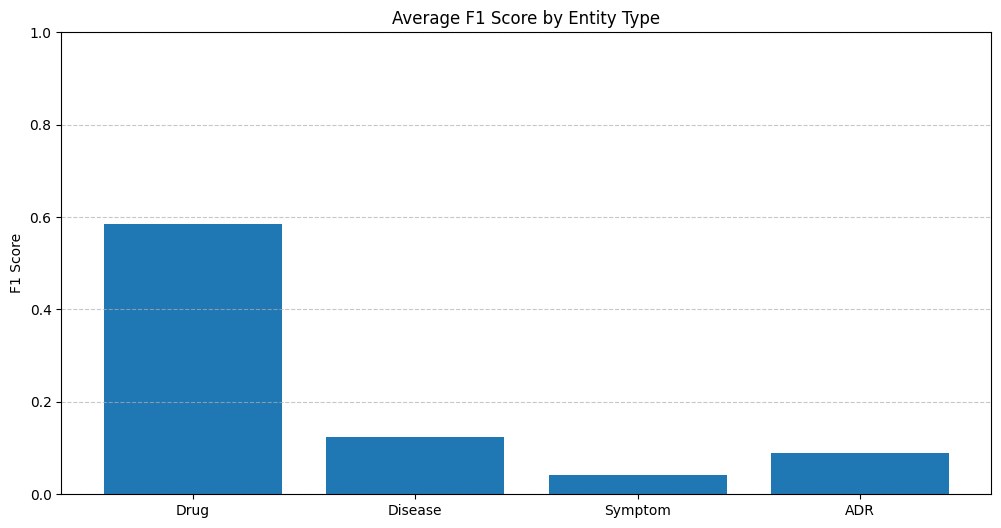

In [46]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thefuzz import fuzz
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

def parse_original_annotations(file_path):
    """
    Parses original .ann files with format like:
    T1  ADR 9 19    bit drowsy
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):  # Skip comments and empty lines
                continue
            
            parts = line.split('\t')
            if len(parts) < 3:
                continue
                
            ann_id = parts[0]
            label_info = parts[1].split()
            if len(label_info) < 3:  # Need at least label, start, end
                continue
                
            label = label_info[0]
            # Handle cases with multiple spans
            spans = []
            i = 1
            while i < len(label_info) - 1 and label_info[i].isdigit() and label_info[i+1].isdigit():
                spans.append((int(label_info[i]), int(label_info[i+1])))
                i += 2
                
            text = parts[2].strip()
            
            # Use the first span for simplicity in case of multiple spans
            if spans:
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': spans[0][0],
                    'end': spans[0][1],
                    'text': text
                })
    
    return annotations

def parse_processed_annotations(file_path):
    """
    Parses structured.txt files with format like:
    T1 ADR 9 19 bit drowsy
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
                
            parts = line.split()
            if len(parts) < 5:  # Skip lines without enough parts
                continue
                
            try:
                ann_id = parts[0]
                label = parts[1]
                start = int(parts[2])
                end = int(parts[3])
                text = " ".join(parts[4:])
                
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': start,
                    'end': end,
                    'text': text
                })
            except (ValueError, IndexError):
                continue  # Skip lines with parsing issues
    
    return annotations

def compute_exact_match(original, processed):
    """Computes exact match metrics for (label, text) pairs"""
    orig_set = {(ann['label'], ann['text'].strip().lower()) for ann in original}
    proc_set = {(ann['label'], ann['text'].strip().lower()) for ann in processed}
    
    common = orig_set.intersection(proc_set)
    precision = len(common) / len(proc_set) if proc_set else 0
    recall = len(common) / len(orig_set) if orig_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def compute_exact_match_by_entity_type(original, processed):
    """Compute exact match metrics broken down by entity type"""
    results = {}
    entity_types = {'ADR', 'Drug', 'Disease', 'Symptom'}
    
    for entity_type in entity_types:
        orig_filtered = [ann for ann in original if ann['label'] == entity_type]
        proc_filtered = [ann for ann in processed if ann['label'] == entity_type]
        
        if orig_filtered or proc_filtered:
            precision, recall, f1 = compute_exact_match(orig_filtered, proc_filtered)
            results[entity_type] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'orig_count': len(orig_filtered),
                'proc_count': len(proc_filtered)
            }
    
    return results

def compute_fuzzy_match(original, processed, threshold=80):
    """Computes fuzzy match scores between original and processed entities"""
    # Group annotations by label
    orig_by_label = defaultdict(list)
    for ann in original:
        orig_by_label[ann['label']].append(ann)
    
    scores = []
    for proc_ann in processed:
        best_ratio = 0
        # Only compare with original annotations of the same label
        if proc_ann['label'] in orig_by_label:
            for orig_ann in orig_by_label[proc_ann['label']]:
                ratio = fuzz.ratio(proc_ann['text'].lower(), orig_ann['text'].lower())
                if ratio > best_ratio:
                    best_ratio = ratio
        scores.append(best_ratio)
    
    # Calculate metrics
    avg_score = np.mean(scores) if scores else 0
    median_score = np.median(scores) if scores else 0
    above_threshold = sum(1 for score in scores if score >= threshold)
    pct_above_threshold = above_threshold / len(scores) if scores else 0
    
    return {
        'avg_score': avg_score,
        'median_score': median_score,
        'pct_above_threshold': pct_above_threshold
    }

def compute_semantic_similarity(original, processed, model):
    """Computes semantic similarity between original and processed entities"""
    if not original or not processed:
        return {
            'avg_similarity': 0,
            'max_similarity': 0,
            'min_similarity': 0
        }
    
    # Group annotations by label for more accurate comparisons
    results_by_label = {}
    overall_similarities = []
    
    for label in {'ADR', 'Drug', 'Disease', 'Symptom'}:
        orig_texts = [ann['text'] for ann in original if ann['label'] == label]
        proc_texts = [ann['text'] for ann in processed if ann['label'] == label]
        
        if not orig_texts or not proc_texts:
            continue
            
        emb_orig = model.encode(orig_texts, convert_to_tensor=True)
        emb_proc = model.encode(proc_texts, convert_to_tensor=True)
        
        cosine_scores = util.cos_sim(emb_proc, emb_orig)
        best_sim_per_proc = cosine_scores.max(dim=1)[0]
        
        # Record similarities for this label
        similarities = best_sim_per_proc.cpu().numpy()
        overall_similarities.extend(similarities)
        
        results_by_label[label] = {
            'avg_similarity': similarities.mean().item(),
            'count': len(similarities)
        }
    
    # Overall stats
    overall = np.array(overall_similarities)
    return {
        'avg_similarity': overall.mean() if len(overall) > 0 else 0,
        'by_label': results_by_label
    }

def boundary_overlap_score(original, processed):
    """
    Computes boundary overlap metrics to assess partial matches.
    """
    scores = []
    
    # Group annotations by label
    orig_by_label = defaultdict(list)
    for ann in original:
        orig_by_label[ann['label']].append(ann)
    
    for proc_ann in processed:
        best_overlap = 0
        label = proc_ann['label']
        proc_start, proc_end = proc_ann['start'], proc_ann['end']
        
        if label in orig_by_label:
            for orig_ann in orig_by_label[label]:
                orig_start, orig_end = orig_ann['start'], orig_ann['end']
                
                # Check if boundaries overlap
                if proc_end > orig_start and orig_end > proc_start:
                    # Compute intersection over union
                    intersection = min(proc_end, orig_end) - max(proc_start, orig_start)
                    union = max(proc_end, orig_end) - min(proc_start, orig_start)
                    overlap = intersection / union if union > 0 else 0
                    if overlap > best_overlap:
                        best_overlap = overlap
        
        scores.append(best_overlap)
    
    return {
        'avg_overlap': np.mean(scores) if scores else 0,
        'pct_with_overlap': sum(1 for s in scores if s > 0) / len(scores) if scores else 0
    }

def main():
    # Define paths
    original_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/input-data/original"
    processed_base_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/processed-output"
    
    # Map files by filename (without extension)
    orig_files = {os.path.splitext(os.path.basename(f))[0]: f 
                  for f in glob.glob(os.path.join(original_dir, "*.ann"))}
    
    # Look for corresponding subdirectories with structured.txt files
    proc_files = {}
    for dirname in os.listdir(processed_base_dir):
        # Check if it's a directory
        dir_path = os.path.join(processed_base_dir, dirname)
        if os.path.isdir(dir_path):
            structured_file = os.path.join(dir_path, "structured.txt")
            if os.path.exists(structured_file):
                proc_files[dirname] = structured_file
    
    common_keys = set(orig_files.keys()).intersection(proc_files.keys())
    if not common_keys:
        print("No matching file pairs found.")
        return
    
    print(f"Found {len(common_keys)} matching file pairs for evaluation.")
    
    # Load a sentence transformer model for semantic similarity
    print("Loading sentence transformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Track results
    overall_results = []
    entity_type_results = defaultdict(lambda: defaultdict(list))
    
    # Process files
    for key in common_keys:
        print(f"\nProcessing file: {key}")
        orig_anns = parse_original_annotations(orig_files[key])
        proc_anns = parse_processed_annotations(proc_files[key])
        
        if not proc_anns:
            print(f"  Warning: No valid annotations found in processed file for {key}")
            continue
            
        # Exact match metrics
        precision, recall, f1 = compute_exact_match(orig_anns, proc_anns)
        
        # Entity type specific metrics
        entity_metrics = compute_exact_match_by_entity_type(orig_anns, proc_anns)
        
        # Fuzzy match metrics
        fuzzy_metrics = compute_fuzzy_match(orig_anns, proc_anns)
        
        # Semantic similarity metrics
        sem_metrics = compute_semantic_similarity(orig_anns, proc_anns, model)
        
        # Boundary overlap metrics
        boundary_metrics = boundary_overlap_score(orig_anns, proc_anns)
        
        # Store results
        file_result = {
            'file': key,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fuzzy_score': fuzzy_metrics['avg_score'],
            'semantic_similarity': sem_metrics['avg_similarity'],
            'boundary_overlap': boundary_metrics['avg_overlap'],
            'entity_metrics': entity_metrics
        }
        
        overall_results.append(file_result)
        
        # Store results by entity type for later aggregation
        for entity_type, metrics in entity_metrics.items():
            for metric_name, value in metrics.items():
                if metric_name in ['precision', 'recall', 'f1']:
                    entity_type_results[entity_type][metric_name].append(value)
        
        # Print result for this file
        print(f"  Exact Match -> Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
        print(f"  Fuzzy Match Score: {fuzzy_metrics['avg_score']:.2f}")
        print(f"  Semantic Similarity: {sem_metrics['avg_similarity']:.2f}")
        print(f"  Boundary Overlap: {boundary_metrics['avg_overlap']:.2f}")
        
        # Print entity-specific metrics
        for entity_type, metrics in entity_metrics.items():
            print(f"  {entity_type}: P={metrics['precision']:.2f}, R={metrics['recall']:.2f}, F1={metrics['f1']:.2f} " +
                  f"(Original: {metrics['orig_count']}, Generated: {metrics['proc_count']})")
    
    # Calculate aggregate metrics
    if overall_results:
        metrics_df = pd.DataFrame(overall_results)
        metrics_df.to_csv('/Users/thyag/Desktop/Assignement/assignment-miimansa/result/evaluation_results.csv', index=False)
        print("\n=== Overall Average Metrics ===")
        print(f"Precision: {metrics_df['precision'].mean():.3f}")
        print(f"Recall: {metrics_df['recall'].mean():.3f}")
        print(f"F1 Score: {metrics_df['f1'].mean():.3f}")
        print(f"Fuzzy Match Score: {metrics_df['fuzzy_score'].mean():.3f}")
        print(f"Semantic Similarity: {metrics_df['semantic_similarity'].mean():.3f}")
        print(f"Boundary Overlap: {metrics_df['boundary_overlap'].mean():.3f}")
        
        # Entity type aggregated metrics
        print("\n=== Entity Type Average Metrics ===")
        for entity_type, metrics in entity_type_results.items():
            if metrics['f1']:  # If we have results for this entity type
                avg_precision = np.mean(metrics['precision'])
                avg_recall = np.mean(metrics['recall'])
                avg_f1 = np.mean(metrics['f1'])
                print(f"{entity_type}: P={avg_precision:.3f}, R={avg_recall:.3f}, F1={avg_f1:.3f}")
        
        # Visualization
        try:
            # Plot F1 scores by entity type
            plt.figure(figsize=(12, 6))
            entity_types = list(entity_type_results.keys())
            f1_scores = [np.mean(entity_type_results[et]['f1']) for et in entity_types]
            
            plt.bar(entity_types, f1_scores)
            plt.title('Average F1 Score by Entity Type')
            plt.ylabel('F1 Score')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            #plt.savefig('entity_type_f1_scores.png')
            print("\nSaved entity type F1 score chart to 'entity_type_f1_scores.png'")
        except Exception as e:
            print(f"Could not create visualization: {e}")

if __name__ == "__main__":
    main()

Found 1240 matching file pairs for ADR evaluation.
Loading sentence transformer model...

File: LIPITOR.374
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 32.00
  Semantic Similarity (cosine): 0.25
  Boundary Overlap: 0.00

File: LIPITOR.39
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 78.00
  Semantic Similarity (cosine): 0.87
  Boundary Overlap: 0.00

File: LIPITOR.699
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 80.00
  Semantic Similarity (cosine): 0.85
  Boundary Overlap: 0.13

File: LIPITOR.28
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 0.00
  Semantic Similarity (cosine): 0.00
  Boundary Overlap: 0.00

File: LIPITOR.487
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 0.00
  Semantic Similarity (cosine): 0.00
  Boundary Overlap: 0.00

File: LIPITOR.551
  Exact Match -> Precision: 0.0

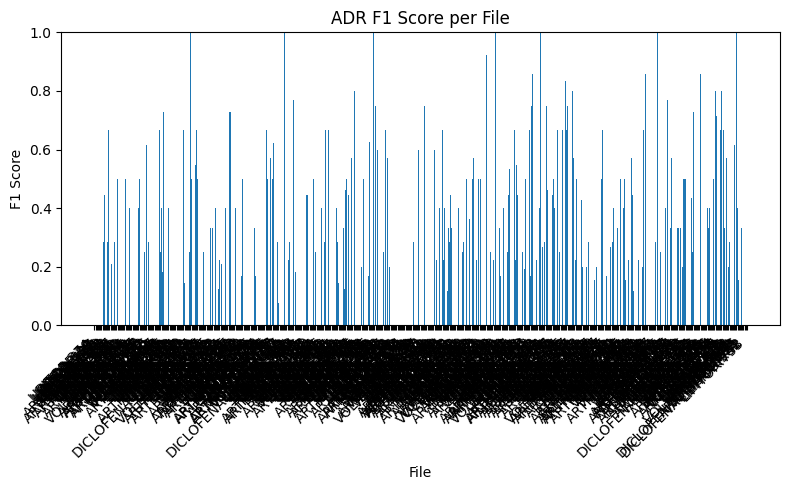

In [49]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thefuzz import fuzz
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

def parse_original_annotations(file_path):
    """
    Parses original MedDRA .ann files where each line is like:
    
    TT1    10028294 53 71    excessive cramping
    TT2    10043890 153 158   tired
    TT3    10016256 159 166   fatigue
    ...
    
    Since these files contain only ADR annotations (without an explicit label),
    this function assigns "ADR" as the label for every annotation.
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            
            parts = line.split('\t')
            if len(parts) < 3:
                continue
            
            ann_id = parts[0]
            # The second column contains numerical information, e.g. "10028294 53 71"
            label_info = parts[1].split()
            if len(label_info) < 3:
                continue
            
            # Force the label to "ADR" since all annotations here are ADRs.
            label = "ADR"
            
            spans = []
            i = 1
            while i < len(label_info) - 1 and label_info[i].isdigit() and label_info[i+1].isdigit():
                spans.append((int(label_info[i]), int(label_info[i+1])))
                i += 2
                
            text = parts[2].strip()
            if spans:
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': spans[0][0],
                    'end': spans[0][1],
                    'text': text
                })
    return annotations

def parse_processed_annotations(file_path):
    """
    Parses structured.txt files with format like:
    T1 ADR 9 19 bit drowsy
    Only retains annotations with label ADR.
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            
            parts = line.split()
            if len(parts) < 5:
                continue
            try:
                ann_id = parts[0]
                label = parts[1]
                # Only keep ADR annotations
                if label != "ADR":
                    continue
                start = int(parts[2])
                end = int(parts[3])
                text = " ".join(parts[4:])
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': start,
                    'end': end,
                    'text': text
                })
            except (ValueError, IndexError):
                continue   
    return annotations

def compute_exact_match(orig, proc):
    """Computes exact match metrics for (label, text) pairs."""
    orig_set = {(ann['label'], ann['text'].strip().lower()) for ann in orig}
    proc_set = {(ann['label'], ann['text'].strip().lower()) for ann in proc}
    
    common = orig_set.intersection(proc_set)
    precision = len(common) / len(proc_set) if proc_set else 0
    recall = len(common) / len(orig_set) if orig_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def compute_fuzzy_match(orig, proc, threshold=80):
    """Computes fuzzy match scores between original and processed ADR entities."""
    scores = []
    for proc_ann in proc:
        best_ratio = 0
        for orig_ann in orig:
            ratio = fuzz.ratio(proc_ann['text'].lower(), orig_ann['text'].lower())
            if ratio > best_ratio:
                best_ratio = ratio
        scores.append(best_ratio)
    avg_score = np.mean(scores) if scores else 0
    median_score = np.median(scores) if scores else 0
    above_threshold = sum(1 for s in scores if s >= threshold)
    pct_above_threshold = above_threshold / len(scores) if scores else 0
    return {
        'avg_score': avg_score,
        'median_score': median_score,
        'pct_above_threshold': pct_above_threshold
    }

def compute_semantic_similarity(orig, proc, model):
    """Computes semantic similarity between original and processed ADR entities using cosine similarity."""
    if not orig or not proc:
        return {'avg_similarity': 0, 'max_similarity': 0, 'min_similarity': 0}
    
    orig_texts = [ann['text'] for ann in orig]
    proc_texts = [ann['text'] for ann in proc]
    
    emb_orig = model.encode(orig_texts, convert_to_tensor=True)
    emb_proc = model.encode(proc_texts, convert_to_tensor=True)
    
    cosine_scores = util.cos_sim(emb_proc, emb_orig)
    best_sim_per_proc = cosine_scores.max(dim=1)[0]
    avg_similarity = best_sim_per_proc.mean().item()
    return {'avg_similarity': avg_similarity}

def boundary_overlap_score(orig, proc):
    """Computes boundary overlap metrics to assess partial matches."""
    scores = []
    for proc_ann in proc:
        best_overlap = 0
        proc_start, proc_end = proc_ann['start'], proc_ann['end']
        for orig_ann in orig:
            orig_start, orig_end = orig_ann['start'], orig_ann['end']
            if proc_end > orig_start and orig_end > proc_start:
                intersection = min(proc_end, orig_end) - max(proc_start, orig_start)
                union = max(proc_end, orig_end) - min(proc_start, orig_start)
                overlap = intersection / union if union > 0 else 0
                if overlap > best_overlap:
                    best_overlap = overlap
        scores.append(best_overlap)
    return {
        'avg_overlap': np.mean(scores) if scores else 0,
        'pct_with_overlap': sum(1 for s in scores if s > 0) / len(scores) if scores else 0
    }

def main():
    # Define paths. Original MedDRA annotations are in the meddra folder
    original_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/input-data/meddra"
    processed_base_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/processed-output"
    
    # Map original files by filename (without extension)
    orig_files = {os.path.splitext(os.path.basename(f))[0]: f 
                  for f in glob.glob(os.path.join(original_dir, "*.ann"))}
    
    # Map processed files via subdirectories containing structured.txt.
    proc_files = {}
    for dirname in os.listdir(processed_base_dir):
        dir_path = os.path.join(processed_base_dir, dirname)
        if os.path.isdir(dir_path):
            structured_file = os.path.join(dir_path, "structured.txt")
            if os.path.exists(structured_file):
                proc_files[dirname] = structured_file
    
    common_keys = set(orig_files.keys()).intersection(proc_files.keys())
    if not common_keys:
        print("No matching file pairs found.")
        return
    print(f"Found {len(common_keys)} matching file pairs for ADR evaluation.")
    
    print("Loading sentence transformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    overall_results = []
    
    # Process each matching pair
    for key in common_keys:
        orig_anns = parse_original_annotations(orig_files[key])
        proc_anns = parse_processed_annotations(proc_files[key])
        
        if not proc_anns:
            print(f"  Warning: No valid processed ADR annotations found for {key}")
            continue
        
        # Compute metrics
        precision, recall, f1 = compute_exact_match(orig_anns, proc_anns)
        fuzzy = compute_fuzzy_match(orig_anns, proc_anns)
        semantic = compute_semantic_similarity(orig_anns, proc_anns, model)
        boundary = boundary_overlap_score(orig_anns, proc_anns)
        
        result = {
            'file': key,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fuzzy_score': fuzzy['avg_score'],
            'semantic_similarity': semantic['avg_similarity'],
            'boundary_overlap': boundary['avg_overlap'],
            'orig_count': len(orig_anns),
            'proc_count': len(proc_anns)
        }
        overall_results.append(result)
        print(f"\nFile: {key}")
        print(f"  Exact Match -> Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
        print(f"  Fuzzy Match Average Score: {fuzzy['avg_score']:.2f}")
        print(f"  Semantic Similarity (cosine): {semantic['avg_similarity']:.2f}")
        print(f"  Boundary Overlap: {boundary['avg_overlap']:.2f}")
    
    if overall_results:
        metrics_df = pd.DataFrame(overall_results)
        # Save results to CSV
        save_path = '/Users/thyag/Desktop/Assignement/assignment-miimansa/result/evaluation_results_ADR.csv'
        metrics_df.to_csv(save_path, index=False)
        print(f"\n=== Overall ADR Evaluation Metrics ===")
        print(f"Precision: {metrics_df['precision'].mean():.3f}")
        print(f"Recall: {metrics_df['recall'].mean():.3f}")
        print(f"F1 Score: {metrics_df['f1'].mean():.3f}")
        print(f"Fuzzy Match Score: {metrics_df['fuzzy_score'].mean():.3f}")
        print(f"Semantic Similarity: {metrics_df['semantic_similarity'].mean():.3f}")
        print(f"Boundary Overlap: {metrics_df['boundary_overlap'].mean():.3f}")
        
        # Optionally, visualize the F1 score distribution for ADR
        plt.figure(figsize=(8, 5))
        plt.bar(metrics_df['file'], metrics_df['f1'])
        plt.title('ADR F1 Score per File')
        plt.ylabel('F1 Score')
        plt.xlabel('File')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig('/Users/thyag/Desktop/Assignement/assignment-miimansa/result/ADR_F1_scores.png')
        print("\nSaved ADR F1 score chart to 'ADR_F1_scores.png'")

if __name__ == "__main__":
    main()

Found 1240 matching file pairs for evaluation.
Evaluating 50 randomly selected file pairs.
Loading sentence transformer model...

File: ARTHROTEC.51
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 61.25
  Semantic Similarity (cosine): 0.74
  Boundary Overlap: 0.39

File: LIPITOR.748
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 34.33
  Semantic Similarity (cosine): 0.38
  Boundary Overlap: 0.02

File: LIPITOR.554
  Exact Match -> Precision: 0.00, Recall: 0.00, F1: 0.00
  Fuzzy Match Average Score: 73.25
  Semantic Similarity (cosine): 0.83
  Boundary Overlap: 0.23

File: LIPITOR.882
  Exact Match -> Precision: 0.11, Recall: 0.40, F1: 0.17
  Fuzzy Match Average Score: 49.78
  Semantic Similarity (cosine): 0.51
  Boundary Overlap: 0.05

File: LIPITOR.934
  Exact Match -> Precision: 0.08, Recall: 0.09, F1: 0.08
  Fuzzy Match Average Score: 88.23
  Semantic Similarity (cosine): 0.91
  Boundary Overlap: 0.43

File

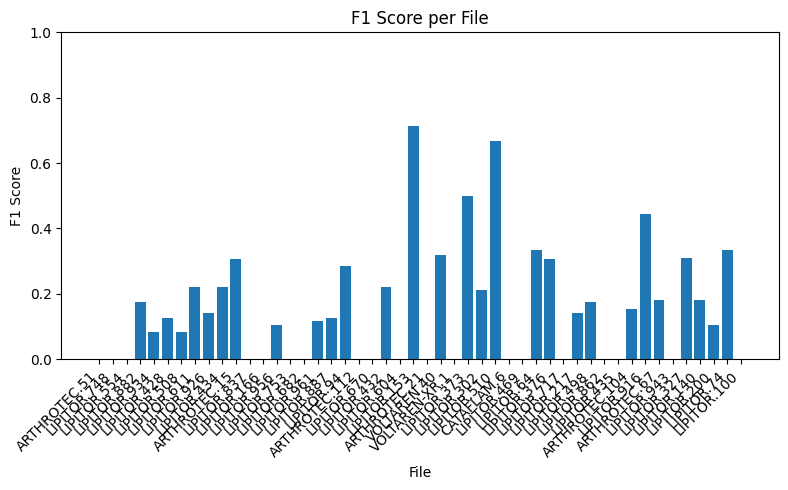

In [51]:
import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thefuzz import fuzz
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict

def parse_original_annotations(file_path):
    """
    Parses original .ann files with format like:
    T1 ADR 9 19    bit drowsy
    or any other label.
    Extracts the label, first span and text.
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            parts = line.split('\t')
            if len(parts) < 3:
                continue

            ann_id = parts[0]
            label_info = parts[1].split()
            if len(label_info) < 3:
                continue

            # Use the actual label
            label = label_info[0]
            
            spans = []
            i = 1
            while i < len(label_info) - 1 and label_info[i].isdigit() and label_info[i+1].isdigit():
                spans.append((int(label_info[i]), int(label_info[i+1])))
                i += 2

            text = parts[2].strip()
            if spans:
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': spans[0][0],
                    'end': spans[0][1],
                    'text': text
                })
    return annotations

def parse_processed_annotations(file_path):
    """
    Parses structured.txt files with format like:
    T1 ADR 9 19 bit drowsy
    This version performs a full comparison by retaining all annotations (without filtering any label).
    """
    annotations = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            parts = line.split()
            if len(parts) < 5:
                continue
            try:
                ann_id = parts[0]
                label = parts[1]
                start = int(parts[2])
                end = int(parts[3])
                text = " ".join(parts[4:])
                annotations.append({
                    'id': ann_id,
                    'label': label,
                    'start': start,
                    'end': end,
                    'text': text
                })
            except (ValueError, IndexError):
                continue   
    return annotations

def compute_exact_match(orig, proc):
    """Computes exact match metrics for (label, text) pairs."""
    orig_set = {(ann['label'], ann['text'].strip().lower()) for ann in orig}
    proc_set = {(ann['label'], ann['text'].strip().lower()) for ann in proc}
    
    common = orig_set.intersection(proc_set)
    precision = len(common) / len(proc_set) if proc_set else 0
    recall = len(common) / len(orig_set) if orig_set else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def compute_fuzzy_match(orig, proc, threshold=80):
    """Computes fuzzy match scores between original and processed entities."""
    scores = []
    for proc_ann in proc:
        best_ratio = 0
        for orig_ann in orig:
            ratio = fuzz.ratio(proc_ann['text'].lower(), orig_ann['text'].lower())
            if ratio > best_ratio:
                best_ratio = ratio
        scores.append(best_ratio)
    avg_score = np.mean(scores) if scores else 0
    median_score = np.median(scores) if scores else 0
    above_threshold = sum(1 for s in scores if s >= threshold)
    pct_above_threshold = above_threshold / len(scores) if scores else 0
    return {
        'avg_score': avg_score,
        'median_score': median_score,
        'pct_above_threshold': pct_above_threshold
    }

def compute_semantic_similarity(orig, proc, model):
    """Computes semantic similarity between original and processed entities using cosine similarity."""
    if not orig or not proc:
        return {'avg_similarity': 0, 'max_similarity': 0, 'min_similarity': 0}
    
    orig_texts = [ann['text'] for ann in orig]
    proc_texts = [ann['text'] for ann in proc]
    
    emb_orig = model.encode(orig_texts, convert_to_tensor=True)
    emb_proc = model.encode(proc_texts, convert_to_tensor=True)
    
    cosine_scores = util.cos_sim(emb_proc, emb_orig)
    best_sim_per_proc = cosine_scores.max(dim=1)[0]
    avg_similarity = best_sim_per_proc.mean().item()
    return {'avg_similarity': avg_similarity}

def boundary_overlap_score(orig, proc):
    """Computes boundary overlap metrics to assess partial matches."""
    scores = []
    for proc_ann in proc:
        best_overlap = 0
        proc_start, proc_end = proc_ann['start'], proc_ann['end']
        for orig_ann in orig:
            orig_start, orig_end = orig_ann['start'], orig_ann['end']
            if proc_end > orig_start and orig_end > proc_start:
                intersection = min(proc_end, orig_end) - max(proc_start, orig_start)
                union = max(proc_end, orig_end) - min(proc_start, orig_start)
                overlap = intersection / union if union > 0 else 0
                if overlap > best_overlap:
                    best_overlap = overlap
        scores.append(best_overlap)
    return {
        'avg_overlap': np.mean(scores) if scores else 0,
        'pct_with_overlap': sum(1 for s in scores if s > 0) / len(scores) if scores else 0
    }

def main():
    # Define paths using the original folder for annotation comparisons.
    original_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/input-data/original"
    processed_base_dir = "/Users/thyag/Desktop/Assignement/assignment-miimansa/dataset/processed-output"
    
    # Map original files by filename (without extension)
    orig_files = {os.path.splitext(os.path.basename(f))[0]: f 
                  for f in glob.glob(os.path.join(original_dir, "*.ann"))}
    
    # Map processed files via subdirectories containing structured.txt.
    proc_files = {}
    for dirname in os.listdir(processed_base_dir):
        dir_path = os.path.join(processed_base_dir, dirname)
        if os.path.isdir(dir_path):
            structured_file = os.path.join(dir_path, "structured.txt")
            if os.path.exists(structured_file):
                proc_files[dirname] = structured_file
    
    # Get matching file pairs
    common_keys = set(orig_files.keys()).intersection(proc_files.keys())
    if not common_keys:
        print("No matching file pairs found.")
        return
    print(f"Found {len(common_keys)} matching file pairs for evaluation.")

    # Optionally, select 50 at random if preferred:
    selected_keys = random.sample(list(common_keys), k=50) if len(common_keys) > 50 else list(common_keys)
    print(f"Evaluating {len(selected_keys)} randomly selected file pairs.")
    # Load sentence transformer model for semantic similarity calculations.
    print("Loading sentence transformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    overall_results = []
    
    # Process each selected pair
    for key in selected_keys:
        orig_anns = parse_original_annotations(orig_files[key])
        proc_anns = parse_processed_annotations(proc_files[key])
        
        if not proc_anns:
            print(f"  Warning: No valid processed annotations found for {key}")
            continue
        
        # Compute metrics
        precision, recall, f1 = compute_exact_match(orig_anns, proc_anns)
        fuzzy = compute_fuzzy_match(orig_anns, proc_anns)
        semantic = compute_semantic_similarity(orig_anns, proc_anns, model)
        boundary = boundary_overlap_score(orig_anns, proc_anns)
        
        result = {
            'file': key,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fuzzy_score': fuzzy['avg_score'],
            'semantic_similarity': semantic['avg_similarity'],
            'boundary_overlap': boundary['avg_overlap'],
            'orig_count': len(orig_anns),
            'proc_count': len(proc_anns)
        }
        overall_results.append(result)
        print(f"\nFile: {key}")
        print(f"  Exact Match -> Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
        print(f"  Fuzzy Match Average Score: {fuzzy['avg_score']:.2f}")
        print(f"  Semantic Similarity (cosine): {semantic['avg_similarity']:.2f}")
        print(f"  Boundary Overlap: {boundary['avg_overlap']:.2f}")
    
    if overall_results:
        metrics_df = pd.DataFrame(overall_results)
        # Save results to CSV
        save_path = '/Users/thyag/Desktop/Assignement/assignment-miimansa/result/evaluation_results_full_comparison.csv'
        metrics_df.to_csv(save_path, index=False)
        print(f"\n=== Overall Evaluation Metrics ===")
        print(f"Precision: {metrics_df['precision'].mean():.3f}")
        print(f"Recall: {metrics_df['recall'].mean():.3f}")
        print(f"F1 Score: {metrics_df['f1'].mean():.3f}")
        print(f"Fuzzy Match Score: {metrics_df['fuzzy_score'].mean():.3f}")
        print(f"Semantic Similarity: {metrics_df['semantic_similarity'].mean():.3f}")
        print(f"Boundary Overlap: {metrics_df['boundary_overlap'].mean():.3f}")
        
        # Optionally, visualize the F1 score distribution
        plt.figure(figsize=(8, 5))
        plt.bar(metrics_df['file'], metrics_df['f1'])
        plt.title('F1 Score per File')
        plt.ylabel('F1 Score')
        plt.xlabel('File')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig('/Users/thyag/Desktop/Assignement/assignment-miimansa/result/full_comparison_F1_scores.png')
        print("\nSaved F1 score chart to 'full_comparison_F1_scores.png'")

if __name__ == "__main__":
    main()